## HAM experiments Segmentation -> Classification

In [60]:
import ipykernel
print(ipykernel.get_connection_file())


/home/jovyan/.local/share/jupyter/runtime/kernel-c05fdf6f-a856-4076-a0b4-6bb03ce79325.json


#### INPUT
- **Training&Validation**: LARGE DATASET immagini dermoscopiche CON DUPLICATI TRANNE CHE NELLA CLASSE NV
- **Test**: ISIC 2018 Challenge Test Set senza duplicati

## Installation of libraries

In [1]:
pip install "numpy<2.0.0" --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-forecasting 0.10.2 requires optuna<3.0.0,>=2.3.0, but you have optuna 3.6.0 which is incompatible.
pytorch-forecasting 0.10.2 requires pandas<2.0.0,>=1.3.0, but you have pandas 2.2.2 which is incompatible.
pytorch-forecasting 0.10.2 requires pytorch-lightning<2.0.0,>=1.2.4, but you have pytorch-lightning 2.2.2 which is incompatible.
pytorch-forecasting 0.10.2 requires scikit-learn<1.2,>=0.24, but you have scikit-learn 1.4.2 which is incompatible.
pytorch-forecast

In [1]:
# Install libraries

!pip install torch torchvision tensorboard
!pip install barbar
!pip install torchsummary
!pip install pytorch-ignite
!pip install timm
!pip install "opencv-python<4.9.0"
!pip install grad-cam

In [2]:
import torch
import os
import random
import torchvision
import pandas as pd
import datetime as dt
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
import timm

from tqdm import tqdm
from sklearn.manifold import TSNE

/opt/conda/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
args = {
    # Dataset for segmentation (HAM)
    'train_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/images/training/',
    'val_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/images/validation/',
    'test_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/HAM_test_segmentation/test_images',

    # Masks for segmentation (HAM)
    'mask_dir_train': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/masks/training/',
    'mask_dir_val': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/masks/validation/',
    'mask_dir_test': '/home/jovyan/nfs/mgallazzi/datasets/HAM_test_segmentation/test_masks',

    # Dataset for classification (HAM)
    'train_dir_class': '/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/training/',
    'val_dir_class': '/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/validation/',  
    'test_dir_class': '/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/',

    'save_dir': 'experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg',
    'num_classes': 7,  # Number of class for classification
    'lambda_multi': 1.0,  # weight for multiclass-loss
    'lambda_bin': 1.0,  # weight for binary-loss
    'batch_size': 144,  # Batch size for training
    'early_stopping': 20,  # Number of epochs for early stopping
    'lr': 0.0001,  # Learning rate
    'alpha': 0.25,  # Specific parameter for the loss weighting
    'device': torch.device("cuda:5" if torch.cuda.is_available() else "cpu"),
}


In [10]:
if os.path.exists(args['save_dir']):
    raise Exception(f"Sorry, the output dir {args['save_dir']} already exists!")  # error...
os.makedirs(args['save_dir'])

Exception: Sorry, the output dir experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg already exists!

In [4]:
class Metrics:
    def __init__(self, column_names):
        column_names.insert(0, "time_stamp")
        self.df = pd.DataFrame(columns=column_names)

    def add_row(self, row_list):
        row_list.insert(0, str(dt.datetime.now()))
        # print(row_list)
        self.df.loc[len(self.df)] = row_list

    def save_to_csv(self, filepath):
        self.df.to_csv(filepath, index=False)

    def load(self, filepath):
        # Load data from the CSV file into the DataFrame
        self.df = pd.read_csv(filepath)

    def get_best_value(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].max()
        else:
            raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    def plot(self, col_names=[], title="", x_label="", y_label="", bottom=None, top=None):
        data2plot = self.df[col_names]
        # ================plot===================
        ax = data2plot.plot(title=title) #figsize=(10,8), 
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(bottom, top)

## Datasets

In [5]:
# Function to count files in a folder by category
def count_files_by_category(base_dir, categories):
    count_by_category = {}
    for category in categories:
        dir_path = os.path.join(base_dir, category)
        count_by_category[category] = len(os.listdir(dir_path))
    return count_by_category

# Function to count all files in a folder (no categories)
def count_total_files(folder):
    return len(os.listdir(folder))

# Define the categories
categories = ['0.MEL', '1.NV', '2.BCC', '3.AKIEC', '4.BKL', '5.DF', '6.VASC']

# Count images and masks for training and validation sets
train_images = count_files_by_category(args['train_dir_seg'], categories)
train_masks = count_files_by_category(args['mask_dir_train'], categories)
val_images = count_files_by_category(args['val_dir_seg'], categories)
val_masks = count_files_by_category(args['mask_dir_val'], categories)
train_classification = count_files_by_category(args['train_dir_class'], categories)
val_classification = count_files_by_category(args['val_dir_class'], categories)
test_classification = count_files_by_category(args['test_dir_class'], categories)

# Create a DataFrame for training and validation sets
df_train_val = pd.DataFrame({
    'Training Images Segmentation': train_images,
    'Training Masks Segmentation': train_masks,
    'Validation Images Segmentation': val_images,
    'Validation Masks Segmentation': val_masks,
    'Training Images Classification': train_classification,
    'Validation Images Classification': val_classification,
    'Test Images Classification': test_classification,
})

# Count images and masks for test set (no categories)
test_images_total = count_total_files(args['test_dir_seg'])
test_masks_total = count_total_files(args['mask_dir_test'])

# Create a separate DataFrame for the test set
df_test = pd.DataFrame({
    'Test Images': [test_images_total],
    'Test Masks': [test_masks_total]
})

# Display the two tables
print("Training and Validation Sets")
display(df_train_val)

print("\nTest Set")
df_test

Training and Validation Sets


,Training Images Segmentation,Training Masks Segmentation,Validation Images Segmentation,Validation Masks Segmentation,Training Images Classification,Validation Images Classification,Test Images Classification
0.MEL,890,890,224,223,890,223,172
1.NV,5364,5364,1341,1341,4322,1081,908
2.BCC,411,411,103,103,411,103,94
3.AKIEC,261,261,66,66,261,66,43
4.BKL,879,879,220,220,879,220,217
5.DF,92,92,23,23,92,23,44
6.VASC,113,113,29,29,113,29,35



Test Set


,Test Images,Test Masks
0,1001,1001


In [6]:
# Definizione della mappatura delle classi binarie dove 1:maligne , 0:benigne
class_mapping = {
    '0.MEL': 1, '1.NV': 0, '2.BCC': 1, '3.AKIEC': 1,
    '4.BKL': 0, '5.DF': 0, '6.VASC': 0
}

# Custom Dataset per ImageFolder with binary labels
class BinaryImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, binary=True, multi=True):
        super(BinaryImageFolder, self).__init__(root, transform=transform)
        self.binary = binary
        self.multiclass = multi
        #self.dataset = datasets.ImageFolder(root, transform=transform)
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print("***Loading:" + root)

    def __getitem__(self, index):
        image, label_multiclass = super(BinaryImageFolder, self).__getitem__(index)
        class_name = self.idx_to_class[label_multiclass]
        label_binaria = class_mapping[class_name]
        return image, label_multiclass, label_binaria


class BinaryOnlyImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, binary=True, multi=False):
        super(BinaryOnlyImageFolder, self).__init__(root, transform=transform)
        self.binary = binary
        self.multiclass = multi
        print("***Loading:" + root)

    def __getitem__(self, index):
        image, label_binary = super(BinaryOnlyImageFolder, self).__getitem__(index)
        return image, -1, label_binary


class MyConcatDataset(ConcatDataset):
    def __init__(self, datasets, binary=True, multi=True):
        super(MyConcatDataset, self).__init__(datasets)
        self.binary = binary
        self.multiclass = multi

In [7]:
class RandomResize:
    def __init__(self, resize_min=224, resize_max=280):
        self.resize_min = resize_min
        self.resize_max = resize_max

    def __call__(self, img):
        # Randomly choose the resize dimensions
        resize_size = random.randint(self.resize_min, self.resize_max)
        resize_transforms = transforms.Resize(resize_size)
        img = resize_transforms(img)
        return img


train_transforms = transforms.Compose([
    RandomResize(224, 280), # transforms.Resize((224, 280)),  # Aumento delle dimensioni a 224x300
    transforms.RandomCrop((224, 224)),  # Applicazione di RandomCrop
    # transforms.Resize((224, 280)),
    # transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  

    # La traslazione sarà casuale con un range di +/-10% rispetto alle dimensioni originali
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),  # Aumento delle dimensioni a 224x300
    transforms.RandomCrop((224, 224)),  # Applicazione di RandomCrop
    # transforms.Resize((224, 280)),
    # torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(224), #(224, 300)),  # PERCHE' IL RESIZE E' DIVERSO DAL VAL?
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def run_test_datasets():
    # Dataset di classificazione per il training
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=True, multi=True)
    
    # Dataset di classificazione per la validazione
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=True, multi=True)
    
    # Dataset di classificazione per il test
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=True, multi=True)

    # Creare DataLoader per classificazione
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)

    return train_loader, val_loader, test_loader

# Esegui la funzione per creare i loader
train_loader, val_loader, test_loader = run_test_datasets()

***Loading:/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/training/
***Loading:/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/validation/
***Loading:/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/


### Segmentation dataset

In [8]:
import torchvision.transforms.functional as TF
from PIL import Image

class ComposeTwo(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomResizeCrop:
    def __init__(self, size=(224,224), resize_min=224, resize_max=280):
        self.size = size
        self.resize_min = resize_min
        self.resize_max = resize_max

    def __call__(self, image, mask):
        new_size = random.randint(self.resize_min, self.resize_max)
        image = TF.resize(image, (new_size, new_size))
        if mask is not None:
            mask = TF.resize(mask, (new_size, new_size), interpolation=Image.NEAREST)
        
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.size)
        image = TF.crop(image, i, j, h, w)
        if mask is not None:
            mask = TF.crop(mask, i, j, h, w)
        return image, mask    

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = TF.hflip(image)
            if mask is not None:
                mask = TF.hflip(mask)
        return image, mask

class RandomAffine:
    def __init__(self, degrees, translate):
        self.degrees = degrees
        self.translate = translate

    def __call__(self, image, mask):
        params = transforms.RandomAffine.get_params(self.degrees, self.translate, None, None, image.size)
        image = TF.affine(image, *params)
        if mask is not None:
            mask = TF.affine(mask, *params)
        return image, mask

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, mask):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        image = TF.rotate(image, angle)
        if mask is not None:
            mask = TF.rotate(mask, angle)
        return image, mask

class ToTensorAndNormalize:
    def __init__(self, mean, std):
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, image, mask):
        image = self.to_tensor(image)
        image = self.normalize(image)
        if mask is not None:
            mask = self.to_tensor(mask)
        return image, mask

# Dataset per training e validazione (con sottocartelle)
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Directory con le immagini di input, con sottocartelle.
            mask_dir (str): Directory con le maschere di segmentazione, con sottocartelle.
            transform (callable, optional): Trasformazioni da applicare sia alle immagini di input che alle maschere.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Estensioni supportate
        valid_extensions = ('.png', '.bmp', '.jpg', '.jpeg', '.tiff')

        # Cerca immagini e maschere nelle sottocartelle rispettando la stessa struttura
        self.image_filenames = []
        self.mask_filenames = []

        for class_folder in os.listdir(image_dir):
            class_image_folder = os.path.join(image_dir, class_folder)
            class_mask_folder = os.path.join(mask_dir, class_folder)

            # Verifica che le sottocartelle esistano sia per le immagini che per le maschere
            if not os.path.exists(class_mask_folder):
                raise ValueError(f"Missing corresponding mask folder for {class_folder}")

            for image_file in os.listdir(class_image_folder):
                if image_file.endswith(valid_extensions):
                    image_path = os.path.join(class_image_folder, image_file)
                    mask_path = os.path.join(class_mask_folder, image_file.replace('.jpg', '.png'))

                    # Aggiungi solo se esistono sia immagine che maschera
                    if os.path.exists(mask_path):
                        self.image_filenames.append(image_path)
                        self.mask_filenames.append(mask_path)
                    else:
                        print(f"Maschera non trovata per {image_file}, saltata.")

        if len(self.image_filenames) == 0:
            raise ValueError(f"Nessuna immagine trovata nella directory: {image_dir}")
        if len(self.mask_filenames) == 0:
            raise ValueError(f"Nessuna maschera trovata nella directory: {mask_dir}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        mask_path = self.mask_filenames[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Converti la maschera in scala di grigi

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Dataset for the test set (no subdirectories by class)
class TestImageSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []
        self.masks = []

        # Load all images and corresponding masks
        for image_file in os.listdir(image_dir):
            # Only consider .jpg files for the images
            if image_file.endswith('.jpg'):
                image_path = os.path.join(image_dir, image_file)

                # The mask file has a .png extension and includes "_segmentation"
                mask_file = image_file.replace('.jpg', '_segmentation.png')
                mask_path = os.path.join(mask_dir, mask_file)

                # Append only if both the image and the mask exist
                if os.path.exists(mask_path):
                    self.images.append(image_path)
                    self.masks.append(mask_path)
                else:
                    print(f"Mask not found for {image_file}, skipping.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")  # Convert the mask to grayscale

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [9]:
def run_test_seg_dataset():
    # Definire le trasformazioni
    seg_transform = ComposeTwo([
        RandomResizeCrop((224, 224), resize_min=224, resize_max=280),
        RandomHorizontalFlip(p=0.5),
        RandomAffine(degrees=(-10,10), translate=(0.1, 0.1)),
        RandomRotation(degrees=(-180, 180)),
        ToTensorAndNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dataset di segmentazione per il training
    train_segmentation_dataset = CustomSegmentationDataset(
        args['train_dir_seg'], args['mask_dir_train'], transform=seg_transform)

    # Dataset di segmentazione per la validazione
    val_segmentation_dataset = CustomSegmentationDataset(
        args['val_dir_seg'], args['mask_dir_val'], transform=seg_transform)

    # Dataset di segmentazione per il test (senza sottocartelle e con "_segmentation" nelle maschere)
    test_segmentation_dataset = TestImageSegmentationDataset(
        args['test_dir_seg'], args['mask_dir_test'], transform=seg_transform)

    # Creare DataLoader per segmentazione
    train_segmentation_loader = DataLoader(train_segmentation_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_segmentation_loader = DataLoader(val_segmentation_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_segmentation_loader = DataLoader(test_segmentation_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)

    # Esegui un esempio per verificare la forma delle immagini e delle maschere
    image, mask = train_segmentation_dataset.__getitem__(0)  # Ottieni il primo esempio dal dataset di training
    print(f"Forma dell'immagine (training): {image.shape}")
    print(f"Forma della maschera (training): {mask.shape}")

    image, mask = test_segmentation_dataset.__getitem__(0)  # Ottieni il primo esempio dal dataset di test
    print(f"Forma dell'immagine (test): {image.shape}")
    print(f"Forma della maschera (test): {mask.shape}")

    return train_segmentation_loader, val_segmentation_loader, test_segmentation_loader

# Esegui la funzione per creare i loader di segmentazione e verifica le forme
train_segmentation_loader, val_segmentation_loader, test_segmentation_loader = run_test_seg_dataset()

Forma dell'immagine (training): torch.Size([3, 224, 224])
Forma della maschera (training): torch.Size([1, 224, 224])
Forma dell'immagine (test): torch.Size([3, 224, 224])
Forma della maschera (test): torch.Size([1, 224, 224])


## Models for classification and segmentation

In [10]:
from timm.layers import SelectAdaptivePool2d
import torch.nn.functional as F

class SwinBase(nn.Module):
    def __init__(self, base_model=None):
        super(SwinBase, self).__init__()
        if base_model is None:
            self.base = timm.create_model('swin_large_patch4_window7_224', pretrained=True)
            self.head_in = self.base.head.in_features
            self.base.head = nn.Identity()
        else:
            self.base = base_model.base
            self.head_in = base_model.head_in

    def load_weights(self, checkpoint_path):
        print("Loading pre-trained:", checkpoint_path)
        self.load_state_dict(torch.load(checkpoint_path))

    def save_weights(self, save_path):
        print("Saving model:", save_path)
        torch.save(self.state_dict(), save_path)


class SwinSeg(SwinBase):
    def __init__(self, base_model=None):
        super(SwinSeg, self).__init__(base_model)

        # Creare un modulo Sequential per l'upsampling
        self.head = nn.Sequential(
            nn.ConvTranspose2d(self.head_in, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.base(x)
        x = x.permute(0, 3, 1, 2)  # Diventa [batch, 1536, 7, 7]
        x = self.head(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

    def convert_to_classification(self, num_classes_multiclass=args['num_classes'], num_classes_binary=2):
        return SwinClassification(base_model=self, num_classes_multiclass=num_classes_multiclass, num_classes_binary=num_classes_binary)


class PermuteDimensions(nn.Module):
    def forward(self, x):
        return x.permute(0, 3, 1, 2)


class SwinClassification(SwinBase):
    def __init__(self, base_model=None, num_classes_multiclass=args['num_classes'], num_classes_binary=2):
        super(SwinClassification, self).__init__(base_model)

        # Definisci la testa del modello usando num_classes_multiclass da args
        self.head = nn.Sequential(
            PermuteDimensions(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(self.head_in, num_classes_multiclass),
            nn.Linear(num_classes_multiclass, num_classes_binary)
        )

    def forward(self, x):
        x = self.base(x)
        x = self.head[0:4](x)
        x_multiclass = self.head[4](x)
        x_binary = self.head[5](x_multiclass)
        return x_multiclass, x_binary

    def convert_to_segmentation(self):
        return SwinSeg(base_model=self)

In [11]:
def run_test():
    input_tensor = torch.randn(1, 3, 224, 224)

    #segmentation_model
    seg_model = SwinSeg()
    seg_model_path = os.path.join(args['save_dir'], 'seg_model.pth')
    out = seg_model(input_tensor)
    print("out seg:", out.shape)

    seg_model.save_weights(seg_model_path)
    seg_model.load_weights(seg_model_path)

    # convert segmentation model into classification model
    cls_model = seg_model.convert_to_classification()
    cls_model_path = os.path.join(args['save_dir'], 'cls_model.pth')
    out1, out2 = cls_model(input_tensor)
    print("out multi:", out1.shape)
    print("out bin:", out2.shape)
    
    cls_model.save_weights(cls_model_path)
    cls_model.load_weights(cls_model_path)

run_test()

out seg: torch.Size([1, 1, 224, 224])
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/seg_model.pth
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/seg_model.pth
out multi: torch.Size([1, 7])
out bin: torch.Size([1, 2])
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/cls_model.pth
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/cls_model.pth


## Training for Segmentation

In [13]:
def iou(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold

    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))

    iou_score = (intersection + 1e-6) / (union + 1e-6) 
    return iou_score.mean().item()


def dice_coeff(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold

    intersection = (pred & target).float().sum((1, 2))
    total = pred.float().sum((1, 2)) + target.float().sum((1, 2))

    dice_score = (2.0 * intersection + 1e-6) / (total + 1e-6)
    return dice_score.mean().item()

In [14]:
def extract_backbone_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            x = model.base(images)             # [B, 7, 7, 1536]
            x = x.mean(dim=[1, 2])             # [B, 1536]
            features.append(x.cpu())
            labels.append(masks.view(masks.size(0), -1).max(dim=1)[0].cpu())  # 1 se lesione presente
    return torch.cat(features), torch.cat(labels)

In [15]:
def plot_tsne(features, labels, save_path, title="t-SNE projection"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    proj = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))
    for label in torch.unique(labels):
        idx = labels == label
        plt.scatter(proj[idx, 0], proj[idx, 1], label=f"Label {int(label)}", alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.savefig(save_path)
    plt.close()

In [16]:
def train_seg_model(model, dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0

    for images, masks in dataloader:
        images = images.to(args['device'])
        masks = masks.to(args['device'])

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        iou_score += iou(outputs, masks) * images.size(0)
        dice_score += dice_coeff(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    iou_score = iou_score / len(dataloader.dataset)
    dice_score = dice_score / len(dataloader.dataset)
    return epoch_loss, iou_score, dice_score


def validate_seg_model(model, dataloader, criterion):
    model.eval()

    running_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(args['device'])
            masks = masks.to(args['device'])

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            iou_score += iou(outputs, masks) * images.size(0)
            dice_score += dice_coeff(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    iou_score = iou_score / len(dataloader.dataset)
    dice_score = dice_score / len(dataloader.dataset)
    return epoch_loss, iou_score, dice_score

In [17]:
def plot_and_save_loss(metrics, save_dir):
    # Estrai le loss
    epochs = metrics['epoch']
    train_loss = metrics['train_loss']
    val_loss = metrics['val_loss']
    test_loss = metrics['test_loss']

    # Plot delle loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    # Salva il grafico
    loss_plot_path = os.path.join(save_dir, 'loss_plot_segmentation.png')
    plt.savefig(loss_plot_path)
    plt.close()

    print(f"Plot delle loss salvato in: {loss_plot_path}")


def plot_and_save_accuracy(metrics, save_dir):
    # Estrai IoU e Dice
    epochs = metrics['epoch']
    train_iou = metrics['train_iou']
    val_iou = metrics['val_iou']
    test_iou = metrics['test_iou']
    
    train_dice = metrics['train_dice']
    val_dice = metrics['val_dice']
    test_dice = metrics['test_dice']

    # Plot di IoU
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_iou, label='Train IoU')
    plt.plot(epochs, val_iou, label='Val IoU')
    plt.plot(epochs, test_iou, label='Test IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU over Epochs')
    plt.legend()
    
    # Salva il grafico di IoU
    iou_plot_path = os.path.join(save_dir, 'iou_plot_segmentation.png')
    plt.savefig(iou_plot_path)
    plt.close()

    print(f"Plot di IoU salvato in: {iou_plot_path}")

    # Plot di Dice coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_dice, label='Train Dice')
    plt.plot(epochs, val_dice, label='Val Dice')
    plt.plot(epochs, test_dice, label='Test Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient over Epochs')
    plt.legend()

    # Salva il grafico di Dice coefficient
    dice_plot_path = os.path.join(save_dir, 'dice_plot_segmentation.png')
    plt.savefig(dice_plot_path)
    plt.close()

    print(f"Plot di Dice salvato in: {dice_plot_path}")
    

In [18]:
def run_training_segmentation():
    # Usa i dataloader per training, validazione e test
    train_loader = train_segmentation_loader
    val_loader = val_segmentation_loader
    test_loader = test_segmentation_loader

    metrics = Metrics(["epoch", "lr", 
                       "train_loss", "train_iou", "train_dice", 
                       "val_loss", "val_iou", "val_dice", 
                       "test_loss", "test_iou", "test_dice"])

    print("Creating new model...")
    model = SwinSeg()  # Usa SwinSeg per la segmentazione

    # Sposta il modello sulla GPU
    model = model.to(args['device'])

    # Definire la loss function e l'ottimizzatore
    criterion = nn.BCEWithLogitsLoss()  # Usare BCEWithLogitsLoss per output a singolo canale e multi-classe
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])

    # Numero di epoche per il training
    num_epochs = 100

    # Variabile per tenere traccia della migliore IoU sulla validazione
    best_val_iou = 0.0

    # Training del modello
    for epoch in range(num_epochs):
        # Fase di training
        epoch_loss, iou_score, dice_score = train_seg_model(model, train_loader, criterion, optimizer)
        
        # Fase di validazione
        val_loss, val_iou, val_dice = validate_seg_model(model, val_loader, criterion)

        # Fase di test
        test_loss, test_iou, test_dice = validate_seg_model(model, test_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train IoU: {iou_score:.4f}, Train Dice: {dice_score:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}")

        # Salvataggio dei risultati
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            epoch_loss, 
            iou_score, 
            dice_score,
            val_loss,
            val_iou,
            val_dice,
            test_loss,
            test_iou,
            test_dice,
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], "metrics_segmentation_review.csv"))

        # Salvataggio del modello corrente
        model.save_weights(os.path.join(args['save_dir'], 'model_seg_last.pt'))

        # Salva il modello se ha la migliore IoU sulla validazione
        if val_iou > best_val_iou:
            print(f"Val IoU migliorata a {val_iou:.4f}, salvataggio del modello migliore.")
            best_val_iou = val_iou
            best_model_path = os.path.join(args['save_dir'], 'model_best_val_iou.pt')
            model.save_weights(best_model_path)
        
            # Estrai feature e salva t-SNE
            features, labels = extract_backbone_features(model, val_loader, args['device'])
            tsne_path = os.path.join(args['save_dir'], f"tsne_seg_epoch{epoch+1}.png")
            plot_tsne(features, labels, tsne_path, title=f"t-SNE Segmentation Epoch {epoch+1}")

    print("Training completato.")

    # Carica le metriche dal file CSV
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_segmentation_review.csv"))

    # Salva i plot di Loss e Accuracy (IoU e Dice coefficient)
    plot_and_save_loss(metrics_data, args['save_dir'])
    plot_and_save_accuracy(metrics_data, args['save_dir'])

# Esegui il training per la segmentazione
run_training_segmentation()

Creating new model...
Epoch 1/100, Train Loss: 0.4641, Train IoU: 0.7717, Train Dice: 0.8188, Val Loss: 0.3760, Val IoU: 0.8636, Val Dice: 0.8976, Test Loss: 0.4150, Test IoU: 0.8089, Test Dice: 0.8534
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_seg_last.pt
Val IoU migliorata a 0.8636, salvataggio del modello migliore.
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou.pt
Epoch 2/100, Train Loss: 0.3525, Train IoU: 0.8781, Train Dice: 0.9083, Val Loss: 0.3303, Val IoU: 0.8903, Val Dice: 0.9183, Test Loss: 0.3795, Test IoU: 0.8337, Test Dice: 0.8746
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_seg_last.pt
Val IoU migliorata a 0.8903, salvataggio del modello migliore.
Saving model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best

### Visualize some results

Opening: ISIC_0021791.jpg
Loading model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou.pt
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou.pt
Plot saved as output_segmentation_ISIC_0021791.pdf


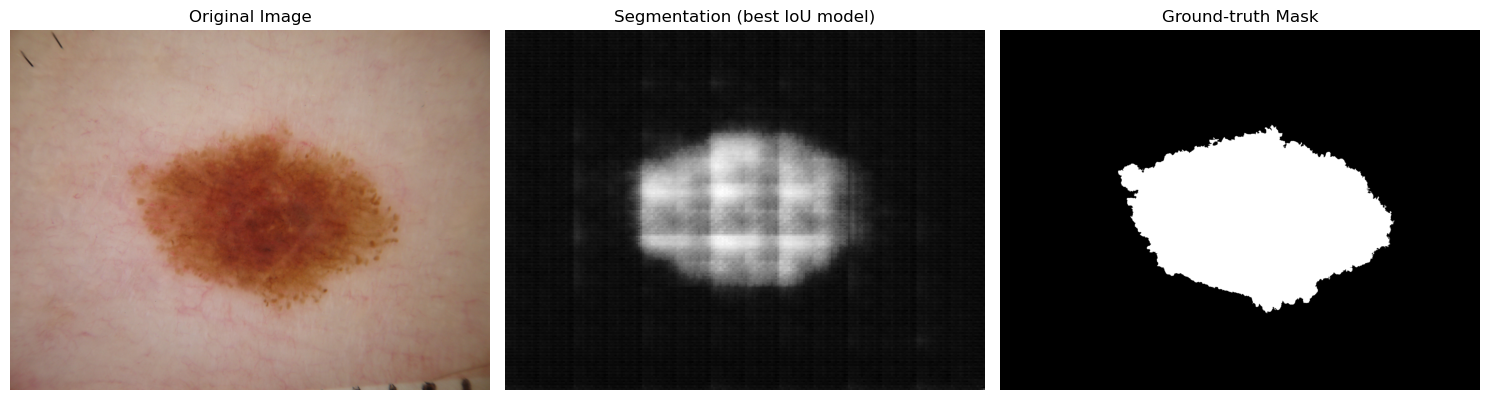

In [18]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import os

def test_seg():
    # Directory immagini e maschere corrette
    img_dir = args['test_dir_seg']
    mask_dir = args['mask_dir_test']

    # Forza l'immagine da usare
    forced_image_name = "ISIC_0021791.jpg"
    base_name = os.path.splitext(forced_image_name)[0]
    forced_mask_name = base_name + "_segmentation.png"
    img_path = os.path.join(img_dir, forced_image_name)
    mask_path = os.path.join(mask_dir, forced_mask_name)

    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        raise FileNotFoundError(f"Immagine o maschera non trovate: {img_path}, {mask_path}")

    print("Opening:", forced_image_name)

    # Caricamento immagine e maschera
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Salva dimensioni originali
    original_size = img.size  # (width, height)

    # --- Resize solo per input al modello (224x224) ---
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized)
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float().unsqueeze(0)  # (1, 3, 224, 224)

    mask_array = np.array(mask)

    # Funzione per eseguire il modello
    def run_model(model_path):
        print(f"Loading model: {model_path}")
        model = SwinSeg()
        model.load_weights(model_path)
        model = model.to(args['device'])
        model.eval()
        with torch.no_grad():
            output = model(img_tensor.to(args['device']))
        segmentation = output.squeeze().cpu().numpy()
        # Resize output to original size (W, H)
        segmentation_resized = cv2.resize(segmentation, original_size, interpolation=cv2.INTER_NEAREST)
        return segmentation_resized

    # Funzione per il plot + salvataggio
    def plot_results(segmentation, real_mask, img, model_name, save_path):
        plt.figure(figsize=(15, 5))

        # Immagine originale
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Maschera predetta
        plt.subplot(1, 3, 2)
        plt.imshow(segmentation, cmap='gray')
        plt.title(f'Segmentation ({model_name})')
        plt.axis('off')

        # Maschera reale (ground-truth)
        plt.subplot(1, 3, 3)
        plt.imshow(real_mask, cmap='gray')
        plt.title('Ground-truth Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Plot saved as {save_path}")
        plt.show()

    # Esegui il modello best IoU
    model_path = os.path.join(args['save_dir'], 'model_best_val_iou.pt')
    segmentation_best = run_model(model_path)

    # Percorso per salvare PDF
    base_filename = os.path.splitext(forced_image_name)[0]
    save_path = f'output_segmentation_{base_filename}.pdf'

    plot_results(segmentation_best, mask_array, img, "best IoU model", save_path)

test_seg()

## Training

Compare the training results when three different combinations of data are used.

In [16]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

device = args['device']

criterion_multi = nn.CrossEntropyLoss()
criterion_binaria = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()

In [21]:
# Funzione per salvare la Confusion Matrix come immagine
def plot_and_save_confusion_matrix(labels, preds, class_names, model_name, save_dir):
    if len(labels) == 0 or len(preds) == 0:
        print(f"Attenzione: Non ci sono dati validi per creare la confusion matrix per il modello {model_name}.")
        return

    conf_matrix = confusion_matrix(labels, preds)
    
    # Controlla se la confusion matrix è vuota
    if conf_matrix.size == 0:
        print(f"Attenzione: La confusion matrix è vuota per il modello {model_name}.")
        return

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix ({model_name})')
    
    # Salva la matrice di confusione come immagine
    cm_path = os.path.join(save_dir, f'confusion_matrix_{model_name}.png')
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix salvata in: {cm_path}")

# Funzione per tracciare e salvare i grafici di loss e accuracy
def plot_and_save_metrics(metrics, save_dir):
    epochs = metrics['epoch']
    
    # Loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss_bin'], label='Train Loss Bin')
    plt.plot(epochs, metrics['val_loss_bin'], label='Val Loss Bin')
    plt.plot(epochs, metrics['test_loss_bin'], label='Test Loss Bin')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Binary Loss over Epochs')
    plt.legend()
    loss_plot_path = os.path.join(save_dir, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot salvato in: {loss_plot_path}")

    # Accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_acc_bin'], label='Train Acc Bin')
    plt.plot(epochs, metrics['val_acc_bin'], label='Val Acc Bin')
    plt.plot(epochs, metrics['test_acc_bin'], label='Test Acc Bin')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Binary Accuracy over Epochs')
    plt.legend()
    acc_plot_path = os.path.join(save_dir, 'accuracy_plot.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f"Accuracy plot salvato in: {acc_plot_path}")

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def save_tsne_plot(model, dataloader, save_path, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, _, labels_bin in dataloader:
            inputs = inputs.to(device)
            labels_bin = labels_bin.to(device)

            feat = model.base(inputs)  # [B, 7, 7, 1536]
            feat = feat.mean(dim=[1, 2])  # Global average pooling → [B, 1536]

            features.append(feat.cpu())
            labels.append(labels_bin.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
    embeddings = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title("t-SNE of Feature Embeddings")
    plt.savefig(save_path)
    plt.close()

In [23]:
# Funzioni di training e validazione
def train_one_epoch(model, train_loader, optimizer, device):
    print('Start training...')
    model.train()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total = 0

    for inputs, labels_multi, labels_bin in train_loader:
        inputs, labels_multi = inputs.to(device), labels_multi.to(device)
        labels_bin = labels_bin.to(device)

        optimizer.zero_grad()
        multiclass_output, binary_output = model(inputs)

        comb_loss = 0
        # Loss multi-classe
        if train_loader.dataset.multiclass:
            loss_multi = criterion_multi(multiclass_output, labels_multi)
            comb_loss += args["lambda_multi"] * loss_multi 

        # Loss binaria
        if train_loader.dataset.binary:
            loss_binaria = criterion_binaria(binary_output, labels_bin)
            comb_loss += args["lambda_bin"] * loss_binaria

        comb_loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        if train_loader.dataset.multiclass:
            running_loss_multi += loss_multi.item()
            _, predicted_multi = torch.max(multiclass_output, dim=1)
            correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()

        if train_loader.dataset.binary:
            running_loss_binaria += loss_binaria.item()
            _, predicted_bin = torch.max(binary_output, dim=1)
            correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()

        total += labels_multi.size(0)

    train_loss_multi = running_loss_multi / len(train_loader)
    train_loss_binaria = running_loss_binaria / len(train_loader)
    train_acc_multi = correct_multi / total
    train_acc_bin = correct_bin / total
    return train_loss_multi, train_loss_binaria, train_acc_multi.cpu().item(), train_acc_bin.cpu().item()

def validate(model, val_loader, device):
    print('Start validation...')
    model.eval()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total_multi = 0
    total_bin = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels_multi, labels_bin in val_loader:
            inputs, labels_multi = inputs.to(device), labels_multi.to(device)
            labels_bin = labels_bin.to(device)

            multiclass_output, binary_output = model(inputs)

            # Loss multi-classe
            if val_loader.dataset.multiclass:
                loss_multi = criterion_multi(multiclass_output, labels_multi)
                running_loss_multi += loss_multi.item()
                _, predicted_multi = torch.max(multiclass_output, dim=1)
                correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()
                total_multi += labels_multi.size(0)
                all_labels.extend(labels_multi.cpu().numpy())
                all_predictions.extend(predicted_multi.cpu().numpy())

            # Loss binaria
            if val_loader.dataset.binary:
                loss_binaria = criterion_binaria(binary_output, labels_bin)
                running_loss_binaria += loss_binaria.item()
                _, predicted_bin = torch.max(binary_output, dim=1)
                correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()
                total_bin += labels_bin.size(0)

    val_loss_multi = running_loss_multi / total_multi if total_multi > 0 else 0
    val_loss_binaria = running_loss_binaria / total_bin if total_bin > 0 else 0

    # Verifica se val_acc_multi_filtered e val_acc_bin sono tensori prima di usare .cpu().item()
    if isinstance(correct_multi, torch.Tensor):
        val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else 0
        val_acc_multi_filtered = val_acc_multi_filtered.cpu().item() if torch.is_tensor(val_acc_multi_filtered) else val_acc_multi_filtered
    else:
        val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else correct_multi

    if isinstance(correct_bin, torch.Tensor):
        val_acc_bin = correct_bin / total_bin if total_bin > 0 else 0
        val_acc_bin = val_acc_bin.cpu().item() if torch.is_tensor(val_acc_bin) else val_acc_bin
    else:
        val_acc_bin = correct_bin / total_bin if total_bin > 0 else correct_bin

    return val_loss_multi, val_loss_binaria, val_acc_multi_filtered, val_acc_bin, all_labels, all_predictions

In [ ]:
# Funzione principale per il training binario
def run_binary_training():
    # Utilizza i dataset di classificazione definiti in args
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=True, multi=False)
    
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=True, multi=False)
    
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=True, multi=False)
    
    # Creazione dei DataLoader per training, validazione e test
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    
    print("\nNumero di esempi nel dataset di training:", len(train_dataset))
    
    # Inizializza le metriche, il modello, l'ottimizzatore, ecc.
    metrics = Metrics(["epoch", "lr", 
                       "train_loss_mult", "train_loss_bin", 
                       "train_acc_multi", "train_acc_bin", 
                       "val_loss_multi", "val_loss_bin", 
                       "val_acc_multi", "val_acc_bin",
                       "test_loss_multi", "test_loss_bin",
                       "test_acc_multi", "test_acc_bin",
                       "best_val_acc"])
    
    # Non caricare il modello di segmentazione pre-addestrato, inizializza un nuovo modello di classificazione
    print("Inizializzazione di un nuovo modello di classificazione...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], num_classes_binary=2)  # Modello di classificazione
    
    model = model.to(args['device'])
    
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    lambda_lr = lambda epoch: 0.95 ** epoch
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)
    
    best_val_acc = 0
    best_test_acc_bin = 0  # Per tracciare il miglior test acc binario
    
    for epoch in range(100):  # Imposta il numero di epoche
        # Fase di training
        train_loss_multi, train_loss_binaria, train_acc, train_acc_bin = train_one_epoch(
            model, train_loader, optimizer, args['device'])
        
        # Fase di validazione
        val_loss_multi, val_loss_binaria, val_acc_multi, val_acc_bin, val_labels, val_preds = validate(
            model, val_loader, args['device'])
        
        # Fase di test
        test_loss_multi, test_loss_binaria, test_acc_multi, test_acc_bin, test_labels, test_preds = validate(
            model, test_loader, args['device'])
        
        scheduler.step()
        
        print(f'Epoca {epoch+1}, Loss Train Bin: {train_loss_binaria:.4f}, '
              f'Acc Train Bin: {train_acc_bin:.4f}, Loss Val Bin: {val_loss_binaria:.4f}, '
              f'Acc Val Bin: {val_acc_bin:.4f}, Loss Test Bin: {test_loss_binaria:.4f}, '
              f'Acc Test Bin: {test_acc_bin:.4f}')
        
        # Salva il modello se l'accuratezza di validazione binaria è migliorata
        if val_acc_bin > best_val_acc:
            print("Miglior Acc Val Bin, salvataggio del modello...")
            best_val_acc = val_acc_bin
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_val_bin.pt'))
        # Salvataggio t-SNE su validazione
            save_tsne_plot(model, val_loader, os.path.join(args['save_dir'], f"tsne_val_epoch{epoch+1}.png"), args['device'])

        
        # Salva il modello se l'accuratezza di test binaria è migliorata
        if test_acc_bin > best_test_acc_bin:
            print("Miglior Acc Test Bin, salvataggio del modello...")
            best_test_acc_bin = test_acc_bin
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_test_bin.pt'))
        
        # Salva il modello ad ogni epoca
        torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_last_bin.pt'))
        
        # Aggiungi i risultati alle metriche
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            train_loss_multi, 
            train_loss_binaria, 
            train_acc, 
            train_acc_bin, 
            val_loss_multi,
            val_loss_binaria,
            val_acc_multi,
            val_acc_bin,
            test_loss_multi, 
            test_loss_binaria, 
            test_acc_multi, 
            test_acc_bin,
            best_val_acc
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], f"metrics_bin5.csv"))
    
    # Salva i grafici delle metriche di loss e accuracy
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_bin5.csv"))
    plot_and_save_metrics(metrics_data, args['save_dir'])

    # Salva la confusion matrix
    class_names = ['Benign', 'Malignant']  # Sostituisci con i nomi delle classi
    #plot_and_save_confusion_matrix(test_labels, test_preds, class_names, "best_test_bin", args['save_dir'])
    plot_and_save_confusion_matrix(val_labels, val_preds, class_names, "best_val_bin", args['save_dir'])
    
    print("Training completato.")

# Esegui la funzione per il training binario usando un nuovo modello di classificazione
run_binary_training()

***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/
***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/
***Loading:/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/

Numero di esempi nel dataset di training: 6968
Inizializzazione di un nuovo modello di classificazione...
Start training...
Start validation...
Start validation...
Epoca 1, Loss Train Bin: 0.3599, Acc Train Bin: 0.8175, Loss Val Bin: 0.0021, Acc Val Bin: 0.8476, Loss Test Bin: 0.0021, Acc Test Bin: 0.8663
Miglior Acc Val Bin, salvataggio del modello...
Miglior Acc Test Bin, salvataggio del modello...
Start training...
Start validation...
Start validation...
Epoca 2, Loss Train Bin: 0.2676, Acc Train Bin: 0.8763, Loss Val Bin: 0.0017, Acc Val Bin: 0.8934, Loss Test Bin: 0.0018, Acc Test Bin: 0.8908
Miglior Acc Val Bin, salvataggio del modello...
Miglior Acc Test Bin, salvataggio del modello...
Start training...
Start validation...
Start

## Training Multiclass 

After loading the binary pretrained model 'model_last_bin.pt', which was trained using all datasets with binary classes, we fine-tune the model with two loss functions for both binary and multi-class classification.

In [18]:
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

def save_tsne_plot_multiclass(
    model, dataloader, device, save_path,
    class_names=None, csv_path=None, title='t-SNE of Multiclass Feature Embeddings',
    annotate_topk=3, random_state=42
):
    model.eval()
    all_features, all_labels = [], []

    with torch.no_grad():
        for inputs, labels_multi, _ in dataloader:
            inputs = inputs.to(device)
            labels_multi = labels_multi.to(device)

            # features prima del classifier
            x = model.base(inputs)                         # [B, H, W, C]
            x = x.permute(0, 3, 1, 2)                      # [B, C, H, W]
            x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))  # [B, C, 1, 1]
            x = x.view(x.size(0), -1)                      # [B, C]

            all_features.append(x.cpu().numpy())
            all_labels.append(labels_multi.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # mapping classi
    if class_names is not None:
        all_labels_named = np.array([class_names[l] for l in all_labels])
    else:
        all_labels_named = all_labels.astype(str)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    reduced = tsne.fit_transform(all_features)

    df = pd.DataFrame({"x": reduced[:, 0], "y": reduced[:, 1], "label": all_labels_named})

    # centroidi e distanze
    centroids = df.groupby("label")[["x", "y"]].mean()
    centroid_labels = centroids.index.to_list()
    centroid_coords = centroids.values

    dist_matrix = cdist(centroid_coords, centroid_coords, metric='euclidean')
    mean_inter = dist_matrix[np.triu_indices_from(dist_matrix, 1)].mean()

    # top-k coppie più vicine
    pairs = []
    for i in range(len(centroid_labels)):
        for j in range(i+1, len(centroid_labels)):
            pairs.append((centroid_labels[i], centroid_labels[j], dist_matrix[i, j]))
    pairs = sorted(pairs, key=lambda z: z[2])
    topk_pairs = pairs[:max(0, annotate_topk)]

    # CSV con matrice distanze
    if csv_path is not None:
        dist_df = pd.DataFrame(dist_matrix, index=centroid_labels, columns=centroid_labels)
        dist_df.to_csv(csv_path, index=True)
        print(f"Inter-class centroid distances salvate in: {csv_path}")

    # plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="x", y="y", hue="label", data=df, palette='tab10', legend='full', alpha=0.6)
    plt.scatter(centroids["x"], centroids["y"], c='black', marker='X', s=100, label='Centroids')

    lines = [f"Mean inter-class centroid distance: {mean_inter:.2f}"]
    for (a, b, d) in topk_pairs:
        lines.append(f"Closest: {a}–{b} = {d:.2f}")
    plt.text(0.02, 0.98, "\n".join(lines), transform=plt.gca().transAxes,
             fontsize=9, va='top', bbox=dict(facecolor='white', alpha=0.75, edgecolor='gray'))

    plt.title(title)
    plt.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"t-SNE multiclass salvato in: {save_path}")
    print(f"Distanza media inter-classe: {mean_inter:.3f}")
    if len(topk_pairs) > 0:
        print("Coppie più vicine:", ", ".join([f"{a}-{b}:{d:.2f}" for a,b,d in topk_pairs]))

    return {
        "mean_interclass_centroid_distance": float(mean_inter),
        "closest_pairs": [(a, b, float(d)) for (a, b, d) in topk_pairs],
        "centroid_labels": centroid_labels
    }

In [26]:
from pathlib import Path
import numpy as cv2
import importlib, cv2

IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean=IMNET_MEAN, std=IMNET_STD):
    # img_tensor: [3,H,W] su CPU
    img = img_tensor.clone()
    for c,(m,s) in enumerate(zip(mean, std)):
        img[c] = img[c]*s + m
    img = (img.clamp(0,1).permute(1,2,0).numpy()*255).astype(np.uint8)
    return img

def overlay_heatmap_on_image(img_bgr, heatmap_01):
    heat = np.uint8(255*np.clip(heatmap_01, 0, 1))
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    return cv2.addWeighted(heat, 0.45, img_bgr, 0.55, 0.0)

# === EXPLANATIONS: GRAD-CAM (head multiclasse) + SALIENCY ===

@torch.no_grad()
def predict_multiclass(model, x):
    logits_multi, _ = model(x)
    return logits_multi

def compute_gradcam_multiclass(model, x, target_index=None):
    """
    Grad-CAM sulla head multiclasse, facendo backprop SOLO fino alle feature spaziali
    (stacchiamo il backbone per ridurre drasticamente la memoria).
    """
    model.eval()

    # 1) Forward backbone -> feature [1,H,W,C], poi DETACH (niente grad nel backbone)
    with torch.no_grad():
        feats = model.base(x)                  # [1,H,W,C]
    feats_chw = feats.permute(0,3,1,2).contiguous()  # [1,C,H,W]
    feats_chw.requires_grad_(True)            # trattiamo queste feature come "leaf"

    # 2) Head multiclasse (riuso moduli)
    pool = model.head[1]      # AdaptiveAvgPool2d
    flat = model.head[2]      # Flatten
    drop = model.head[3]      # Dropout
    fc_m = model.head[4]      # Linear multiclasse

    pooled = pool(feats_chw)              # [1,C,1,1]
    vec = flat(pooled)                    # [1,C]
    vec = drop(vec)
    logits = fc_m(vec)                    # [1,num_classes]

    if target_index is None:
        target_index = int(logits.argmax(dim=1)[0].item())

    score = logits[:, target_index].sum()

    # 3) Grad rispetto a feats_chw (no retain_graph, così libera subito)
    grads = torch.autograd.grad(
        outputs=score,
        inputs=feats_chw,
        retain_graph=False,
        create_graph=False,
        allow_unused=False
    )[0]  # [1,C,H,W]

    # 4) CAM
    weights = grads.mean(dim=(2,3), keepdim=True)      # [1,C,1,1]
    cam = (weights * feats_chw).sum(dim=1, keepdim=False)[0]  # [H,W]
    cam = F.relu(cam)
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()

    return cam.detach().cpu().numpy(), int(target_index)

def compute_vanilla_saliency(model, x, target_index=None, smooth_grad=False, sg_samples=8, sg_noise=0.10):
    """
    Saliency robusta (Input×Grad + percentile norm). Nessun AMP per evitare underflow FP16.
    x: [1,3,H,W] su device
    smooth_grad: True per SmoothGrad (media su sg_samples con rumore gaussiano).
    """
    model.eval()

    def _one_pass(x1, tgt_idx):
        x1 = x1.detach().clone().requires_grad_(True)             # leaf tensor con grad
        logits_multi, _ = model(x1)                                # FP32
        if tgt_idx is None:
            tgt_idx = int(logits_multi.argmax(dim=1)[0].item())
        score = logits_multi[:, tgt_idx].sum()
        model.zero_grad(set_to_none=True)
        if x1.grad is not None: x1.grad.zero_()
        score.backward()
        grad = x1.grad.detach()[0]                                 # [3,H,W]
        sal = (grad * x1.detach()[0]).abs()                        # Input×Grad, [3,H,W]
        sal = sal.max(dim=0)[0]                                    # [H,W]
        return sal, tgt_idx

    if smooth_grad:
        tgt = None if target_index is None else int(target_index)
        acc = None
        for s in range(sg_samples):
            noise = torch.randn_like(x) * sg_noise
            sal_s, tgt = _one_pass(x + noise, tgt)
            acc = sal_s if acc is None else (acc + sal_s)
        sal = acc / float(sg_samples)
        target_index = tgt
    else:
        sal, target_index = _one_pass(x, target_index)

    # Percentile normalization (robusta)
    sal_np = sal.detach().cpu().numpy()
    p_low, p_high = np.percentile(sal_np, [1, 99])
    sal_np = np.clip((sal_np - p_low) / max(p_high - p_low, 1e-6), 0.0, 1.0)
    return sal_np

def save_gradcam_and_saliency(images, cams, sals, out_dir, stems):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(len(stems)):
        img_rgb = denormalize(images[i].cpu())
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        H, W = img_bgr.shape[:2]
        cam_r = cv2.resize(cams[i], (W, H), interpolation=cv2.INTER_CUBIC)
        sal_r = cv2.resize(sals[i], (W, H), interpolation=cv2.INTER_CUBIC)

        cam_over = overlay_heatmap_on_image(img_bgr, cam_r)
        sal_vis  = cv2.applyColorMap(np.uint8(255*sal_r), cv2.COLORMAP_BONE)

        stem = stems[i]
        cv2.imwrite(str(out_dir / f"{stem}_gradcam.jpg"), cam_over)
        cv2.imwrite(str(out_dir / f"{stem}_saliency.jpg"), sal_vis)

def run_test_with_explanations_multiclass(
    model, test_loader, device, save_dir_expl,
    limit_per_class=20,          # metto un default prudente
    use_ground_truth=False,
    do_saliency=False            # puoi attivarla dopo che CAM gira stabile
):
    model = model.to(device).eval()
    save_dir_expl = Path(save_dir_expl); save_dir_expl.mkdir(parents=True, exist_ok=True)

    counts = {}
    global_idx = 0

    for batch_idx, (inputs, labels_multi, labels_bin) in enumerate(test_loader):
        inputs = inputs.to(device, non_blocking=True)
        labels_multi = labels_multi.to(device, non_blocking=True)

        cams, sals, stems, imgs_for_save = [], [], [], []

        B = inputs.size(0)
        for i in range(B):
            x1 = inputs[i:i+1]

            # 1) Grad-CAM (classe predetta o GT) - backbone DETACHED (vedi Patch 1)
            if use_ground_truth:
                tgt = int(labels_multi[i].item())
                cam, pred_idx = compute_gradcam_multiclass(model, x1, target_index=tgt)
                target_idx = tgt
            else:
                cam, pred_idx = compute_gradcam_multiclass(model, x1, target_index=None)
                target_idx = pred_idx

            # Limite per classe (evita migliaia di immagini)
            if limit_per_class is not None:
                counts[target_idx] = counts.get(target_idx, 0)
                if counts[target_idx] >= limit_per_class:
                    # libera e salta
                    del x1, cam
                    continue
                counts[target_idx] += 1

            # 2) Saliency opzionale
            if do_saliency:
                try:
                    sal = compute_vanilla_saliency(model, x1, target_index=target_idx)
                except RuntimeError as e:
                    # Se anche così va OOM, salta la saliency per questo sample
                    print(f"[warn] saliency OOM/err: {e}; salto saliency per questo sample")
                    sal = None
            else:
                sal = None

            cams.append(cam)
            sals.append(sal)
            imgs_for_save.append(inputs[i].detach().cpu())
            real_name = get_image_path_from_loader(test_loader, batch_idx, i)
            stem = Path(real_name).stem  # nome file senza estensione
            stems.append(stem)

            # Aggressivo: pulisci subito
            del x1
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Salvataggio batch
        if len(stems):
            imgs_for_save = torch.stack(imgs_for_save, dim=0)
            # sostituisci None con mappa nera se saliency è off
            if any(s is None for s in sals):
                sals = [(np.zeros_like(c) if s is None else s) for c, s in zip(cams, sals)]
            save_gradcam_and_saliency(imgs_for_save, cams, sals, save_dir_expl, stems)

        # ancora pulizia
        del inputs, labels_multi, labels_bin, cams, sals, stems, imgs_for_save
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def get_image_path_from_loader(loader, batch_idx, item_idx):
    """
    Recupera il path reale dell'immagine dal dataset ImageFolder o BinaryImageFolder.
    """
    dataset = loader.dataset
    global_index = batch_idx * loader.batch_size + item_idx
    if hasattr(dataset, "samples"):
        path, _ = dataset.samples[global_index]
    elif hasattr(dataset, "imgs"):  # compatibilità vecchia torchvision
        path, _ = dataset.imgs[global_index]
    else:
        path = f"img_{global_index:06d}"
    return os.path.basename(path)

In [27]:
import json

from pathlib import Path

def get_image_path_from_loader(loader, batch_idx, item_idx):
    dataset = loader.dataset
    global_index = batch_idx * loader.batch_size + item_idx
    if hasattr(dataset, "samples"):
        path, _ = dataset.samples[global_index]
    elif hasattr(dataset, "imgs"):
        path, _ = dataset.imgs[global_index]
    else:
        return f"img_{global_index:06d}"
    return os.path.basename(path)

def select_fixed_samples_per_class(train_dataset, per_class=1, seed=42, save_json=None):
    """
    Seleziona in modo deterministico un set di immagini (una per classe).
    Ritorna un dizionario {class_idx: [dataset_index, ...]}.
    """
    samples = train_dataset.samples
    per_class_indices = {}
    for idx, (_, y) in enumerate(samples):
        per_class_indices.setdefault(int(y), []).append(idx)

    rng = random.Random(seed)
    selected = {}
    for c, idxs in per_class_indices.items():
        if len(idxs) == 0:
            continue
        take = min(per_class, len(idxs))
        selected[c] = rng.sample(idxs, take)

    if save_json:
        os.makedirs(os.path.dirname(save_json), exist_ok=True)
        with open(save_json, "w") as f:
            json.dump(selected, f, indent=2)
        print(f"✔️ Indici selezionati salvati in {save_json}")

    return selected

def save_train_gradcams_one_per_class(
    model,
    train_dataset,
    device,
    save_dir,
    class_names=None,
    per_class=1,
    use_transform=None,
    epoch=0,
    fixed_indices=None
):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    # <<< FIX: serve SEMPRE, anche se usiamo fixed_indices >>>
    samples = train_dataset.samples  # list[(path,label)]

    # Usa indici fissi se forniti
    if fixed_indices is not None:
        selected = [(idx, cls_idx) for cls_idx, idxs in fixed_indices.items() for idx in idxs]
    else:
        per_class_indices = {}
        for idx, (_, y) in enumerate(samples):
            per_class_indices.setdefault(int(y), []).append(idx)
        rng = random.Random(42 + int(epoch))
        selected = []
        for c, idxs in per_class_indices.items():
            if len(idxs) == 0: 
                continue
            take = min(per_class, len(idxs))
            chosen = rng.sample(idxs, take)
            for gi in chosen:
                selected.append((gi, c))

    # trasformazione (meglio NO augment)
    tfm = use_transform if use_transform is not None else getattr(train_dataset, "transform", None)
    if tfm is None:
        raise RuntimeError("Nessuna transform trovata; passa use_transform=val_transforms")

    # loop: CAM su classe GT
    for ds_idx, cls_idx in selected:
        img_path, _ = samples[ds_idx]
        pil = train_dataset.loader(img_path) if hasattr(train_dataset, "loader") else Image.open(img_path).convert("RGB")
        x = tfm(pil).unsqueeze(0).to(device)  # [1,3,H,W]

        try:
            cam, _ = compute_gradcam_multiclass(model, x, target_index=int(cls_idx))
        except RuntimeError as e:
            print(f"[warn] CAM fallita per {img_path}: {e}")
            continue

        stem = Path(img_path).stem
        img_rgb = denormalize(x[0].detach().cpu())
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        H, W = img_bgr.shape[:2]
        cam_r = cv2.resize(cam, (W, H), interpolation=cv2.INTER_CUBIC)
        cam_over = overlay_heatmap_on_image(img_bgr, cam_r)

        cls_name = str(cls_idx) if class_names is None else class_names[int(cls_idx)]
        save_path = Path(save_dir) / f"{stem}_e{epoch+1}_trainCAM_{cls_name}.jpg"
        cv2.imwrite(str(save_path), cam_over)

        del x
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"✔️ Grad-CAM training (1 per classe, epoca {epoch+1}) salvate in: {save_dir}")

def compute_gradcam_multiclass(model, x, target_index=None):
    """
    Grad-CAM sulla head multiclasse, facendo backprop SOLO fino alle feature spaziali
    (stacchiamo il backbone per ridurre drasticamente la memoria).
    """
    model.eval()

    # 1) Forward backbone -> feature [1,H,W,C], poi DETACH (niente grad nel backbone)
    with torch.no_grad():
        feats = model.base(x)                  # [1,H,W,C]
    feats_chw = feats.permute(0,3,1,2).contiguous()  # [1,C,H,W]
    feats_chw.requires_grad_(True)            # trattiamo queste feature come "leaf"

    # 2) Head multiclasse (riuso moduli)
    pool = model.head[1]      # AdaptiveAvgPool2d
    flat = model.head[2]      # Flatten
    drop = model.head[3]      # Dropout
    fc_m = model.head[4]      # Linear multiclasse

    pooled = pool(feats_chw)              # [1,C,1,1]
    vec = flat(pooled)                    # [1,C]
    vec = drop(vec)
    logits = fc_m(vec)                    # [1,num_classes]

    if target_index is None:
        target_index = int(logits.argmax(dim=1)[0].item())

    score = logits[:, target_index].sum()

    # 3) Grad rispetto a feats_chw (no retain_graph, così libera subito)
    grads = torch.autograd.grad(
        outputs=score,
        inputs=feats_chw,
        retain_graph=False,
        create_graph=False,
        allow_unused=False
    )[0]  # [1,C,H,W]

    # 4) CAM
    weights = grads.mean(dim=(2,3), keepdim=True)      # [1,C,1,1]
    cam = (weights * feats_chw).sum(dim=1, keepdim=False)[0]  # [H,W]
    cam = F.relu(cam)
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()

    return cam.detach().cpu().numpy(), int(target_index)

def save_gradcam_visualizations(
    model,
    dataloader,
    device,
    save_dir,
    target_task='multiclass',
    class_names=None,
    num_images=16
):
    """
    Salva Grad-CAM su un sottoinsieme del validation set:
    - usa compute_gradcam_multiclass (classe predetta)
    - salva con nome file reale.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    saved = 0
    for b_idx, (images, labels_multi, labels_bin) in enumerate(dataloader):
        if saved >= num_images:
            break

        images = images.to(device, non_blocking=True)

        for i in range(images.size(0)):
            if saved >= num_images:
                break

            x1 = images[i:i+1]
            try:
                cam, pred_idx = compute_gradcam_multiclass(model, x1, target_index=None)
            except RuntimeError as e:
                print(f"[warn] CAM val fallita batch {b_idx} idx {i}: {e}")
                continue

            # nome reale
            real_name = get_image_path_from_loader(dataloader, b_idx, i)
            stem = Path(real_name).stem
            cls_tag = f"pred_{pred_idx}" if class_names is None else f"pred_{class_names[int(pred_idx)]}"

            # overlay
            img_rgb = denormalize(x1[0].detach().cpu())
            img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
            H, W = img_bgr.shape[:2]
            cam_r = cv2.resize(cam, (W, H), interpolation=cv2.INTER_CUBIC)
            cam_over = overlay_heatmap_on_image(img_bgr, cam_r)

            out_path = Path(save_dir) / f"{stem}_VALcam_{cls_tag}.jpg"
            cv2.imwrite(str(out_path), cam_over)
            saved += 1

        del images
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"✔️ Salvate {saved} Grad-CAM di validation in: {save_dir}")

In [28]:
# Funzioni di training e validazione
def train_one_epoch_multi(model, train_loader, optimizer, device):
    print('Start training...')
    model.train()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total = 0

    for inputs, labels_multi, labels_bin in train_loader:
        inputs, labels_multi = inputs.to(device), labels_multi.to(device)
        labels_bin = labels_bin.to(device)

        optimizer.zero_grad()
        multiclass_output, binary_output = model(inputs)

        comb_loss = 0
        # Loss multi-classe
        if train_loader.dataset.multiclass:
            loss_multi = criterion_multi(multiclass_output, labels_multi)
            comb_loss += args["lambda_multi"] * loss_multi 

        # Loss binaria
        if train_loader.dataset.binary:
            loss_binaria = criterion_binaria(binary_output, labels_bin)
            comb_loss += args["lambda_bin"] * loss_binaria

        comb_loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        if train_loader.dataset.multiclass:
            running_loss_multi += loss_multi.item()
            _, predicted_multi = torch.max(multiclass_output, dim=1)
            correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()

        if train_loader.dataset.binary:
            running_loss_binaria += loss_binaria.item()
            _, predicted_bin = torch.max(binary_output, dim=1)
            correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()

        total += labels_multi.size(0)

    train_loss_multi = running_loss_multi / len(train_loader)
    train_loss_binaria = running_loss_binaria / len(train_loader)
    train_acc_multi = correct_multi / total
    train_acc_bin = correct_bin / total
    return train_loss_multi, train_loss_binaria, train_acc_multi, train_acc_bin

def validate_multi(model, val_loader, device):
    print('Start validation...')
    model.eval()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total_multi = 0
    total_bin = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels_multi, labels_bin in val_loader:
            inputs, labels_multi = inputs.to(device), labels_multi.to(device)
            labels_bin = labels_bin.to(device)

            multiclass_output, binary_output = model(inputs)

            # Loss multi-classe
            if val_loader.dataset.multiclass:
                loss_multi = criterion_multi(multiclass_output, labels_multi)
                running_loss_multi += loss_multi.item()
                _, predicted_multi = torch.max(multiclass_output, dim=1)
                correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()
                total_multi += labels_multi.size(0)
                all_labels.extend(labels_multi.cpu().numpy())
                all_predictions.extend(predicted_multi.cpu().numpy())

            # Loss binaria
            if val_loader.dataset.binary:
                loss_binaria = criterion_binaria(binary_output, labels_bin)
                running_loss_binaria += loss_binaria.item()
                _, predicted_bin = torch.max(binary_output, dim=1)
                correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()
                total_bin += labels_bin.size(0)

    val_loss_multi = running_loss_multi / total_multi if total_multi > 0 else 0
    val_loss_binaria = running_loss_binaria / total_bin if total_bin > 0 else 0

    val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else 0
    val_acc_bin = correct_bin / total_bin if total_bin > 0 else 0

    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return val_loss_multi, val_loss_binaria, val_acc_multi_filtered, val_acc_bin, conf_matrix

def to_cpu(x):
    # Controlla se è un tensore e se sì lo sposta sulla CPU e ottiene il valore scalare
    return x.cpu().item() if isinstance(x, torch.Tensor) else x

# Funzione per tracciare e salvare i grafici di loss e accuracy
def plot_and_save_metrics_multi(metrics_data, save_dir):
    epochs = metrics_data['epoch']

    # Loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_data['train_loss_mult'], label='Train Loss')
    plt.plot(epochs, metrics_data['val_loss_multi'], label='Validation Loss')
    plt.plot(epochs, metrics_data['test_loss_multi'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Multiclass Loss over Epochs')
    plt.legend()
    loss_plot_path = os.path.join(save_dir, 'multiclass_loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot salvato in: {loss_plot_path}")

    # Accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_data['train_acc_multi'], label='Train Accuracy')
    plt.plot(epochs, metrics_data['val_acc_multi'], label='Validation Accuracy')
    plt.plot(epochs, metrics_data['test_acc_multi'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Multiclass Accuracy over Epochs')
    plt.legend()
    acc_plot_path = os.path.join(save_dir, 'multiclass_accuracy_plot.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f"Accuracy plot salvato in: {acc_plot_path}")

In [29]:
def run_multiclass_training():
    # === Dataset e Dataloader ===
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=False, multi=True)
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=False, multi=True)
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=False, multi=True)

    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True,  num_workers=8)
    val_loader   = DataLoader(val_dataset,   batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader  = DataLoader(test_dataset,  batch_size=args['batch_size'], shuffle=False, num_workers=8)

    print("\nNumero di esempi nel dataset di training:", len(train_dataset))

    # === Metriche ===
    metrics = Metrics(["epoch", "lr", 
                       "train_loss_mult", "train_loss_bin", 
                       "train_acc_multi", "train_acc_bin", 
                       "val_loss_multi", "val_loss_bin", 
                       "val_acc_multi", "val_acc_bin",
                       "test_loss_multi", "test_loss_bin",
                       "test_acc_multi", "test_acc_bin",
                       "best_val_acc", "conf_matrix"])

    # === Modello ===
    print("Creazione del nuovo modello...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], num_classes_binary=2)
    model_path = os.path.join(args['save_dir'], 'model_best_val_bin.pt')
    model.load_state_dict(torch.load(model_path, map_location=args['device']))
    model = model.to(args['device'])

    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

    best_val_acc_multi = 0.0

    # === Seleziona UNA volta le immagini fisse (1 per classe) per le CAM del training ===
    fixed_cam_indices = select_fixed_samples_per_class(
        train_dataset=train_dataset,
        per_class=1,                  # 1 immagine per classe
        seed=123,                     # fisso -> sempre le stesse
        save_json=os.path.join(args['save_dir'], 'fixed_train_cam_indices.json')
    )

    CLASS_NAMES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    # === Training loop ===
    for epoch in range(100):
        # ---- Train ----
        train_loss_multi, train_loss_binaria, train_acc_multi, train_acc_bin = train_one_epoch_multi(
            model, train_loader, optimizer, args['device'])

        # ---- Val & Test ----
        val_loss_multi, val_loss_binaria, val_acc_multi_t, val_acc_bin, val_conf_matrix = validate_multi(
            model, val_loader, args['device'])
        test_loss_multi, test_loss_binaria, test_acc_multi_t, test_acc_bin, test_conf_matrix = validate_multi(
            model, test_loader, args['device'])

        scheduler.step()

        # ---- Log ----
        print(f'Epoca {epoch+1}, Loss Train Multi: {train_loss_multi:.4f}, '
              f'Acc Train Multi: {to_cpu(train_acc_multi):.4f}, Loss Val Multi: {val_loss_multi:.4f}, '
              f'Acc Val Multi: {to_cpu(val_acc_multi_t):.4f}, Loss Test Multi: {test_loss_multi:.4f}, '
              f'Acc Test Multi: {to_cpu(test_acc_multi_t):.4f}')

        # ---- Best checkpoint + artefatti (solo se migliora la val multiclasse) ----
        curr_val_acc = to_cpu(val_acc_multi_t)
        if curr_val_acc > best_val_acc_multi:
            print("Miglior acc val multi-classe, salvataggio del modello e artefatti...")
            best_val_acc_multi = curr_val_acc
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_val_bin+multi.pt'))

            # t-SNE su validation
            res = save_tsne_plot_multiclass(
                model=model,
                dataloader=val_loader,
                device=args['device'],
                save_path=os.path.join(args['save_dir'], f'tsne_best_val_multi_epoch_{epoch+1}.png'),
                csv_path=os.path.join(args['save_dir'], f'centroid_dists_epoch_{epoch+1}.csv'),
                class_names=CLASS_NAMES,
                title=f't-SNE (val) – epoch {epoch+1}',
                annotate_topk=3,
                random_state=42
            )
            print("Mean inter-class centroid distance:", res["mean_interclass_centroid_distance"])
            print("Closest class pairs:", res["closest_pairs"])
        
            # Stampa i valori principali per log o debug
            print("Mean inter-class centroid distance:", res["mean_interclass_centroid_distance"])
            print("Closest class pairs:", res["closest_pairs"])

            # Grad-CAM su validation (come già avevi)
            save_gradcam_visualizations(
                model=model,
                dataloader=val_loader,
                device=args['device'],
                save_dir=os.path.join(args['save_dir'], f'gradcam_best_val_multi_epoch_{epoch+1}'),
                target_task='multiclass',
                class_names=CLASS_NAMES
            )

            # === NEW: Grad-CAM dal TRAIN (sempre le STESSE 7 immagini — 1 per classe) ===
            save_train_gradcams_one_per_class(
                model=model,
                train_dataset=train_dataset,
                device=args['device'],
                save_dir=os.path.join(args['save_dir'], f'train_gradcam_best_val_epoch_{epoch+1}'),
                class_names=CLASS_NAMES,
                per_class=1,                 # 1 per classe
                use_transform=val_transforms, # NO augment
                epoch=epoch,
                fixed_indices=fixed_cam_indices   # <-- indici fissi
            )

        # ---- Save "last" ad ogni epoca ----
        torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_last_bin+multi.pt'))

        # ---- Aggiorna metriche ----
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, lr,
            train_loss_multi, train_loss_binaria,
            to_cpu(train_acc_multi), to_cpu(train_acc_bin),
            val_loss_multi, val_loss_binaria,
            to_cpu(val_acc_multi_t), to_cpu(val_acc_bin),
            test_loss_multi, test_loss_binaria,
            to_cpu(test_acc_multi_t), to_cpu(test_acc_bin),
            best_val_acc_multi,
            f"{test_conf_matrix}",
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], f"metrics_bin+multi5.csv"))

    # === Plot finali ===
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_bin+multi5.csv"))
    plot_and_save_metrics_multi(metrics_data, args['save_dir'])
    print("Training completato.")

# Esegui la funzione per il training multi-classe
run_multiclass_training()

***Loading:/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/training/
***Loading:/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/validation/
***Loading:/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/

Numero di esempi nel dataset di training: 6968
Creazione del nuovo modello...
✔️ Indici selezionati salvati in experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/fixed_train_cam_indices.json
Start training...
Start validation...
Start validation...
Epoca 1, Loss Train Multi: 1.5933, Acc Train Multi: 0.6287, Loss Val Multi: 0.0063, Acc Val Multi: 0.7553, Loss Test Multi: 0.0070, Acc Test Multi: 0.6986
Miglior acc val multi-classe, salvataggio del modello e artefatti...
Inter-class centroid distances salvate in: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/centroid_dists_epoch_1.csv
t-SNE multiclass salvato in: expe

## Test with duplicates
#### For having another type of validation we want to use another dataset given by the ISIC challenge 2018. The number of images of this dataset is 1511.
####

In [15]:
# Funzione per formattare i valori in percentuale
def format_percentage(value):
    return f"{value * 100:.2f}"

# Funzione per calcolare Sensitivity e Specificity
def calculate_sensitivity_specificity(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    return sensitivity, specificity

# Funzione per plottare la confusion matrix
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion Matrix salvata in: {save_path}")
    plt.show()

In [16]:
from pathlib import Path
import numpy as cv2
import importlib, cv2

IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean=IMNET_MEAN, std=IMNET_STD):
    # img_tensor: [3,H,W] su CPU
    img = img_tensor.clone()
    for c,(m,s) in enumerate(zip(mean, std)):
        img[c] = img[c]*s + m
    img = (img.clamp(0,1).permute(1,2,0).numpy()*255).astype(np.uint8)
    return img

def overlay_heatmap_on_image(img_bgr, heatmap_01):
    heat = np.uint8(255*np.clip(heatmap_01, 0, 1))
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    return cv2.addWeighted(heat, 0.45, img_bgr, 0.55, 0.0)

In [23]:
# === EXPLANATIONS: GRAD-CAM (head multiclasse) + SALIENCY ===

@torch.no_grad()
def predict_multiclass(model, x):
    logits_multi, _ = model(x)
    return logits_multi

def compute_gradcam_multiclass(model, x, target_index=None):
    """
    Grad-CAM sulla head multiclasse, facendo backprop SOLO fino alle feature spaziali
    (stacchiamo il backbone per ridurre drasticamente la memoria).
    """
    model.eval()

    # 1) Forward backbone -> feature [1,H,W,C], poi DETACH (niente grad nel backbone)
    with torch.no_grad():
        feats = model.base(x)                  # [1,H,W,C]
    feats_chw = feats.permute(0,3,1,2).contiguous()  # [1,C,H,W]
    feats_chw.requires_grad_(True)            # trattiamo queste feature come "leaf"

    # 2) Head multiclasse (riuso moduli)
    pool = model.head[1]      # AdaptiveAvgPool2d
    flat = model.head[2]      # Flatten
    drop = model.head[3]      # Dropout
    fc_m = model.head[4]      # Linear multiclasse

    pooled = pool(feats_chw)              # [1,C,1,1]
    vec = flat(pooled)                    # [1,C]
    vec = drop(vec)
    logits = fc_m(vec)                    # [1,num_classes]

    if target_index is None:
        target_index = int(logits.argmax(dim=1)[0].item())

    score = logits[:, target_index].sum()

    # 3) Grad rispetto a feats_chw (no retain_graph, così libera subito)
    grads = torch.autograd.grad(
        outputs=score,
        inputs=feats_chw,
        retain_graph=False,
        create_graph=False,
        allow_unused=False
    )[0]  # [1,C,H,W]

    # 4) CAM
    weights = grads.mean(dim=(2,3), keepdim=True)      # [1,C,1,1]
    cam = (weights * feats_chw).sum(dim=1, keepdim=False)[0]  # [H,W]
    cam = F.relu(cam)
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()

    return cam.detach().cpu().numpy(), int(target_index)

def compute_vanilla_saliency(model, x, target_index=None, smooth_grad=False, sg_samples=8, sg_noise=0.10):
    """
    Saliency robusta (Input×Grad + percentile norm). Nessun AMP per evitare underflow FP16.
    x: [1,3,H,W] su device
    smooth_grad: True per SmoothGrad (media su sg_samples con rumore gaussiano).
    """
    model.eval()

    def _one_pass(x1, tgt_idx):
        x1 = x1.detach().clone().requires_grad_(True)             # leaf tensor con grad
        logits_multi, _ = model(x1)                                # FP32
        if tgt_idx is None:
            tgt_idx = int(logits_multi.argmax(dim=1)[0].item())
        score = logits_multi[:, tgt_idx].sum()
        model.zero_grad(set_to_none=True)
        if x1.grad is not None: x1.grad.zero_()
        score.backward()
        grad = x1.grad.detach()[0]                                 # [3,H,W]
        sal = (grad * x1.detach()[0]).abs()                        # Input×Grad, [3,H,W]
        sal = sal.max(dim=0)[0]                                    # [H,W]
        return sal, tgt_idx

    if smooth_grad:
        tgt = None if target_index is None else int(target_index)
        acc = None
        for s in range(sg_samples):
            noise = torch.randn_like(x) * sg_noise
            sal_s, tgt = _one_pass(x + noise, tgt)
            acc = sal_s if acc is None else (acc + sal_s)
        sal = acc / float(sg_samples)
        target_index = tgt
    else:
        sal, target_index = _one_pass(x, target_index)

    # Percentile normalization (robusta)
    sal_np = sal.detach().cpu().numpy()
    p_low, p_high = np.percentile(sal_np, [1, 99])
    sal_np = np.clip((sal_np - p_low) / max(p_high - p_low, 1e-6), 0.0, 1.0)
    return sal_np

def save_gradcam_and_saliency(images, cams, sals, out_dir, stems):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(len(stems)):
        img_rgb = denormalize(images[i].cpu())
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        H, W = img_bgr.shape[:2]
        cam_r = cv2.resize(cams[i], (W, H), interpolation=cv2.INTER_CUBIC)
        sal_r = cv2.resize(sals[i], (W, H), interpolation=cv2.INTER_CUBIC)

        cam_over = overlay_heatmap_on_image(img_bgr, cam_r)
        sal_vis  = cv2.applyColorMap(np.uint8(255*sal_r), cv2.COLORMAP_BONE)

        stem = stems[i]
        cv2.imwrite(str(out_dir / f"{stem}_gradcam.jpg"), cam_over)
        cv2.imwrite(str(out_dir / f"{stem}_saliency.jpg"), sal_vis)

def run_test_with_explanations_multiclass(
    model, test_loader, device, save_dir_expl,
    limit_per_class=20,          # metto un default prudente
    use_ground_truth=False,
    do_saliency=False            # puoi attivarla dopo che CAM gira stabile
):
    model = model.to(device).eval()
    save_dir_expl = Path(save_dir_expl); save_dir_expl.mkdir(parents=True, exist_ok=True)

    counts = {}
    global_idx = 0

    for batch_idx, (inputs, labels_multi, labels_bin) in enumerate(test_loader):
        inputs = inputs.to(device, non_blocking=True)
        labels_multi = labels_multi.to(device, non_blocking=True)

        cams, sals, stems, imgs_for_save = [], [], [], []

        B = inputs.size(0)
        for i in range(B):
            x1 = inputs[i:i+1]

            # 1) Grad-CAM (classe predetta o GT) - backbone DETACHED (vedi Patch 1)
            if use_ground_truth:
                tgt = int(labels_multi[i].item())
                cam, pred_idx = compute_gradcam_multiclass(model, x1, target_index=tgt)
                target_idx = tgt
            else:
                cam, pred_idx = compute_gradcam_multiclass(model, x1, target_index=None)
                target_idx = pred_idx

            # Limite per classe (evita migliaia di immagini)
            if limit_per_class is not None:
                counts[target_idx] = counts.get(target_idx, 0)
                if counts[target_idx] >= limit_per_class:
                    # libera e salta
                    del x1, cam
                    continue
                counts[target_idx] += 1

            # 2) Saliency opzionale
            if do_saliency:
                try:
                    sal = compute_vanilla_saliency(model, x1, target_index=target_idx)
                except RuntimeError as e:
                    # Se anche così va OOM, salta la saliency per questo sample
                    print(f"[warn] saliency OOM/err: {e}; salto saliency per questo sample")
                    sal = None
            else:
                sal = None

            cams.append(cam)
            sals.append(sal)
            imgs_for_save.append(inputs[i].detach().cpu())
            real_name = get_image_path_from_loader(test_loader, batch_idx, i)
            stem = Path(real_name).stem  # nome file senza estensione
            stems.append(stem)

            # Aggressivo: pulisci subito
            del x1
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Salvataggio batch
        if len(stems):
            imgs_for_save = torch.stack(imgs_for_save, dim=0)
            # sostituisci None con mappa nera se saliency è off
            if any(s is None for s in sals):
                sals = [(np.zeros_like(c) if s is None else s) for c, s in zip(cams, sals)]
            save_gradcam_and_saliency(imgs_for_save, cams, sals, save_dir_expl, stems)

        # ancora pulizia
        del inputs, labels_multi, labels_bin, cams, sals, stems, imgs_for_save
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def get_image_path_from_loader(loader, batch_idx, item_idx):
    """
    Recupera il path reale dell'immagine dal dataset ImageFolder o BinaryImageFolder.
    """
    dataset = loader.dataset
    global_index = batch_idx * loader.batch_size + item_idx
    if hasattr(dataset, "samples"):
        path, _ = dataset.samples[global_index]
    elif hasattr(dataset, "imgs"):  # compatibilità vecchia torchvision
        path, _ = dataset.imgs[global_index]
    else:
        path = f"img_{global_index:06d}"
    return os.path.basename(path)

Confusion Matrix salvata in: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_confusion_matrix.png


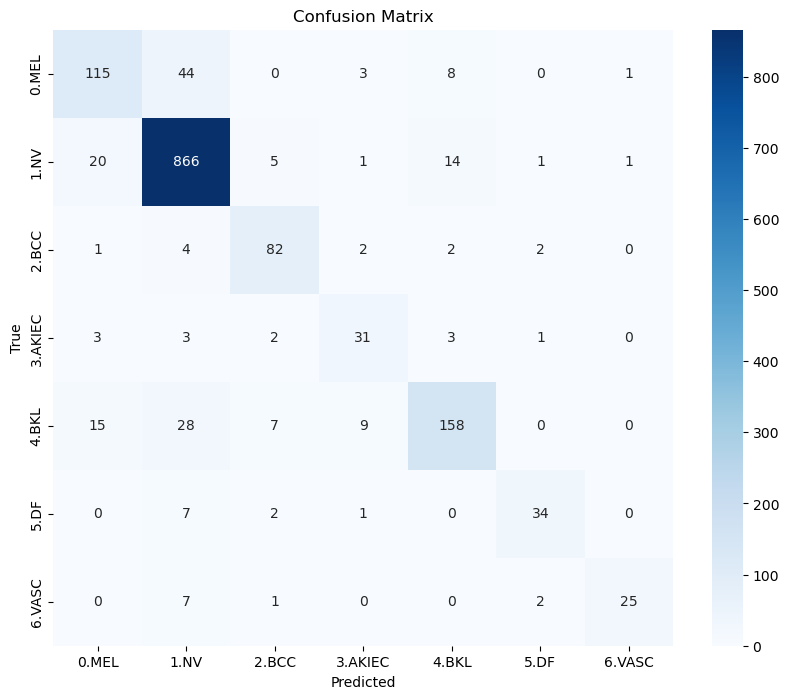


*** METRICHE DI CLASSIFICAZIONE ***
                       precision   recall   f1-score   support

0.MEL                   74.68     67.25       70.77      171.0
1.NV                    90.30     95.37       92.77      908.0
2.BCC                   82.83     88.17       85.42       93.0
3.AKIEC                 65.96     72.09       68.89       43.0
4.BKL                   85.41     72.81       78.61      217.0
5.DF                    85.00     77.27       80.95       44.0
6.VASC                  92.59     71.43       80.65       35.0

accuracy                            86.76

AUC Totale (Macro-Average): 0.9772
AUC Totale (Weighted-Average): 0.9724

ROC AUC per classe:
0.MEL               0.9533
1.NV                0.9738
2.BCC               0.9930
3.AKIEC             0.9864
4.BKL               0.9656
5.DF                0.9860
6.VASC              0.9823

Sensitivity per classe:
0.MEL               0.6725
1.NV                0.9537
2.BCC               0.8817
3.AKIEC             0.720

In [18]:
# Caricamento del modello per la classificazione multiclasse
device = args["device"]
model_path = os.path.join(args['save_dir'], 'model_last_bin+multi2.pt')

# Definisci il modello per la classificazione multiclasse
model = SwinClassification(num_classes_multiclass=args['num_classes'], num_classes_binary=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Inizializza i tensori per le predizioni e le etichette vere
predlist_test_multi = torch.zeros(0, dtype=torch.long, device='cpu')
labels_multi_multi = torch.zeros(0, dtype=torch.long, device='cpu')

# Probabilità per calcolo ROC e AUC
proba_test_multi = torch.zeros(0, device='cpu')

# Esegui il test senza gradiente
with torch.no_grad():
    for i, (inputs, labels_multi, labels_bin) in enumerate(test_loader):  # Usa test_loader per la classificazione
        inputs = inputs.to(device)
        labels_multi = labels_multi.to(device)

        # Ottieni le predizioni del modello
        multiclass_output, _ = model(inputs)  # Prendi solo l'output multiclasse
        preds_multi = torch.argmax(multiclass_output, dim=1)  # Predizione della classe
        proba_test_multi = torch.cat([proba_test_multi, multiclass_output.softmax(dim=1).cpu()])
        
        # Append batch prediction results
        predlist_test_multi = torch.cat([predlist_test_multi, preds_multi.view(-1).cpu()])
        labels_multi_multi = torch.cat([labels_multi_multi, labels_multi.view(-1).cpu()])

# Conversione dei tensori in numpy per l'elaborazione successiva
predlist_test_multi = predlist_test_multi.numpy()
labels_multi_multi = labels_multi_multi.numpy()
proba_test_multi = proba_test_multi.numpy()

# Confusion Matrix per la classificazione multiclasse
conf_matrix = confusion_matrix(labels_multi_multi, predlist_test_multi)

# Definisci i nomi delle classi per la classificazione multiclasse
class_names = ['0.MEL', '1.NV', '2.BCC', '3.AKIEC', '4.BKL', '5.DF', '6.VASC']

# Plot della confusion matrix
cm_save_path = os.path.join(args['save_dir'], 'Test_confusion_matrix.png')
plot_confusion_matrix(conf_matrix, class_names, save_path=cm_save_path)

# Calcolo delle metriche: ROC, AUC, Sensitivity e Specificity
roc_auc_dict = {}
sensitivity_dict = {}
specificity_dict = {}

for i, class_name in enumerate(class_names):
    y_true = (labels_multi_multi == i).astype(int)  # Verità per la classe corrente (one-vs-all)
    y_score = proba_test_multi[:, i]  # Probabilità per la classe corrente
    
    # ROC AUC
    if len(set(y_true)) > 1:  # Calcola solo se ci sono sia 0 che 1 nella classe
        roc_auc_dict[class_name] = roc_auc_score(y_true, y_score)
    
    # Sensitivity e Specificity
    y_pred = (predlist_test_multi == i).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred)
    sensitivity_dict[class_name] = sensitivity
    specificity_dict[class_name] = specificity

# Calcolo delle AUC totali (macro e weighted)
y_true_binarized = label_binarize(labels_multi_multi, classes=list(range(len(class_names))))  # Binarizza i target
auc_macro = roc_auc_score(y_true_binarized, proba_test_multi, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_true_binarized, proba_test_multi, average="weighted", multi_class="ovr")

# Report di classificazione
report = classification_report(labels_multi_multi, predlist_test_multi, target_names=class_names, output_dict=True)

# Formattazione del report
formatted_report = "                       precision   recall   f1-score   support\n\n"
for class_name in class_names:
    precision = format_percentage(report[class_name]['precision'])
    recall = format_percentage(report[class_name]['recall'])
    f1_score = format_percentage(report[class_name]['f1-score'])
    support = report[class_name]['support']
    formatted_report += f"{class_name:<20}{precision:>9}    {recall:>6}    {f1_score:>8}   {support:>8}\n"

# Aggiungi le medie, l'accuratezza e le AUC totali
accuracy = format_percentage(report['accuracy'])
formatted_report += f"\naccuracy                           {accuracy:>6}\n"
formatted_report += f"\nAUC Totale (Macro-Average): {auc_macro:.4f}\n"
formatted_report += f"AUC Totale (Weighted-Average): {auc_weighted:.4f}\n"

# Aggiungi ROC AUC, Sensitivity e Specificity
formatted_report += "\nROC AUC per classe:\n"
for class_name, auc_value in roc_auc_dict.items():
    formatted_report += f"{class_name:<20}{auc_value:.4f}\n"

formatted_report += "\nSensitivity per classe:\n"
for class_name, sensitivity in sensitivity_dict.items():
    formatted_report += f"{class_name:<20}{sensitivity:.4f}\n"

formatted_report += "\nSpecificity per classe:\n"
for class_name, specificity in specificity_dict.items():
    formatted_report += f"{class_name:<20}{specificity:.4f}\n"

# Stampa diretta delle metriche
print("\n*** METRICHE DI CLASSIFICAZIONE ***")
print(formatted_report)

# Salva il report in un file
report_path = os.path.join(args['save_dir'], 'Test_classification_report.txt')
with open(report_path, 'w') as f:
    f.write(formatted_report)
print(f"Report salvato in: {report_path}")

# ROC per ogni classe
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:  # Calcola solo se ci sono sia 0 che 1 nella classe
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc_dict[class_name]:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Classe')
plt.legend(loc='lower right')

# Salva il plot per le classi
roc_classes_path = os.path.join(args['save_dir'], 'Test_roc_curve_classes.png')
plt.savefig(roc_classes_path)
plt.close()
print(f"ROC Curve per classe salvata in: {roc_classes_path}")

# Macro e Weighted ROC
plt.figure(figsize=(12, 8))

# Macro-Average Curve
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(len(class_names)):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_interp = np.interp(fpr_macro, fpr, tpr)  # Interpolazione
        tpr_macro += tpr_interp
tpr_macro /= len(class_names)
auc_macro_curve = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, 'r--', label=f"Macro-Average ROC (AUC = {auc_macro_curve:.4f})")

# Weighted-Average Curve
fpr_weighted = np.linspace(0, 1, 100)
tpr_weighted = np.zeros_like(fpr_weighted)
weights = [sum(labels_multi_multi == i) for i in range(len(class_names))]  # Numero di esempi per classe

for i in range(len(class_names)):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_interp = np.interp(fpr_weighted, fpr, tpr)  # Interpolazione
        tpr_weighted += tpr_interp * weights[i]
tpr_weighted /= sum(weights)
auc_weighted_curve = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, 'g--', label=f"Weighted-Average ROC (AUC = {auc_weighted_curve:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Macro e Weighted ROC Curve')
plt.legend(loc='lower right')

# Salva il plot per Macro e Weighted
roc_macro_weighted_path = os.path.join(args['save_dir'], 'Test_roc_curve_macro_weighted.png')
plt.savefig(roc_macro_weighted_path)
plt.close()
print(f"Macro e Weighted ROC Curve salvata in: {roc_macro_weighted_path}")

In [24]:
# === ESECUZIONE: salva Grad-CAM + Saliency per il test set ===
expl_dir = os.path.join(args['save_dir'], 'Test_explanations_multiclass')
run_test_with_explanations_multiclass(
    model=model,
    test_loader=test_loader,
    device=device,
    save_dir_expl=expl_dir,
    limit_per_class=20,      # es. 20 per classe → ~140 immagini totali
    use_ground_truth=False,  # o True se vuoi sulla classe GT
    do_saliency=False        # prima fai girare CAM; poi metti True se vuoi anche saliency
)
print(f"Grad-CAM (e saliency se attiva) salvate in: {expl_dir}")

Grad-CAM (e saliency se attiva) salvate in: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_explanations_multiclass


In [19]:
# === estrai originale + overlay contorno maschera per una lista di id, 
#     salvando nello stesso folder dove sono le Grad-CAM ===
import os, re, shutil, glob
from pathlib import Path
import numpy as np
import cv2

# --- helper: lista file per estensioni ---
def _list_all(root, exts=(".jpg",".jpeg",".png",".bmp",".tif",".tiff")):
    root = Path(root)
    files = []
    for ext in exts:
        files += list(root.rglob(f"*{ext}"))
    return files

# --- helper: trova immagine per stem in più roots ---
def _find_by_stem(roots, stem_or_name, exts=(".jpg",".jpeg",".png",".bmp",".tif",".tiff")):
    targets, name_lower = [], stem_or_name.lower()
    for r in roots:
        for p in _list_all(r, exts):
            if p.stem.lower() == Path(name_lower).stem or p.name.lower() == name_lower:
                targets.append(p)
    return targets

def _read_image_bgr(path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Impossibile leggere immagine: {path}")
    return img

def _to_tensor(img_rgb_np):
    # img_rgb_np: HxWx3, 0..255
    x = torch.from_numpy(img_rgb_np).permute(2,0,1).float().unsqueeze(0)  # (1,3,H,W), float32
    return x

def _predict_prob_map(model, img_bgr, device, input_size=224, use_imagenet_norm=False):
    H, W = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (input_size, input_size), interpolation=cv2.INTER_LINEAR)

    x = resized.astype(np.float32) / 255.0
    if use_imagenet_norm:
        mean = np.array([0.485,0.456,0.406], dtype=np.float32)
        std  = np.array([0.229,0.224,0.225], dtype=np.float32)
        x = (x - mean) / std

    x = _to_tensor((x*255.0 if not use_imagenet_norm else x).astype(np.float32))
    if not use_imagenet_norm:
        # se non normalizzi, scala a [0..1] per coerenza
        x = x / 255.0

    x = x.to(device)

    model.eval()
    with torch.no_grad():
        y = model(x)                           # atteso: (1,1,h,w) o (1,h,w)
        if y.ndim == 4 and y.shape[1] == 1:
            y = torch.sigmoid(y)               # logits -> prob
            prob = y.squeeze(0).squeeze(0)
        elif y.ndim == 3:
            prob = torch.sigmoid(y).squeeze(0) # (1,h,w)
        else:
            # fallback multiclass: prendi canale 1 come "lesione"
            prob = torch.softmax(y, dim=1)[:,1:2].squeeze(0).squeeze(0)

    prob_np = prob.cpu().numpy().astype(np.float32)  # (h,w) in [0,1]
    prob_up = cv2.resize(prob_np, (W, H), interpolation=cv2.INTER_LINEAR)
    return prob_up  # [0,1] alla risoluzione originale

def predict_and_save_masks_for_stems(
    stems,
    image_roots,
    gradcam_dir,
    model_path,
    device="cuda",
    input_size=224,
    threshold=0.5,
    save_colormap=True,
    overwrite=False,
    use_imagenet_norm=False
):
    """
    Per ciascuno stem:
      - salva copia originale: *_orig.jpg/png
      - salva maschera predetta binaria: *_pred_mask.png (0/255)
      - salva (opzionale) mappa probabilità colorata: *_pred_mask_color.png
    """
    gradcam_dir = Path(gradcam_dir)
    gradcam_dir.mkdir(parents=True, exist_ok=True)

    # Carica modello UNA VOLTA (best IoU)
    print(f"[INFO] Loading model: {model_path}")
    model = SwinSeg()
    model.load_weights(model_path)    # tua API custom
    model = model.to(device).eval()

    saved = []
    for stem in stems:
        # trova immagine
        hits_img = _find_by_stem(image_roots, stem)
        if len(hits_img) == 0:
            print(f"[skip] Immagine non trovata per {stem}")
            continue
        img_path = hits_img[0]
        img_bgr = _read_image_bgr(img_path)

        # salva originale (copia byte-per-byte se possibile)
        ext = Path(img_path).suffix.lower()
        out_orig = gradcam_dir / f"{stem}_orig{ext if ext in ('.jpg','.jpeg','.png') else '.jpg'}"
        if overwrite or not out_orig.exists():
            try:
                # prova copia raw
                import shutil
                shutil.copy2(img_path, out_orig)
            except Exception:
                cv2.imwrite(str(out_orig), img_bgr)

        # predici mappa probabilità e binarizza
        prob = _predict_prob_map(
            model, img_bgr, device=device,
            input_size=input_size,
            use_imagenet_norm=use_imagenet_norm
        )
        mask_bin = (prob >= float(threshold)).astype(np.uint8) * 255

        out_pred = gradcam_dir / f"{stem}_pred_mask.png"
        if overwrite or not out_pred.exists():
            cv2.imwrite(str(out_pred), mask_bin)

        if save_colormap:
            prob_255 = (np.clip(prob, 0, 1) * 255).astype(np.uint8)
            color = cv2.applyColorMap(prob_255, cv2.COLORMAP_VIRIDIS)
            out_color = gradcam_dir / f"{stem}_pred_mask_color.png"
            if overwrite or not out_color.exists():
                cv2.imwrite(str(out_color), color)
        else:
            out_color = None

        print(f"✔ {stem}:")
        print("   - originale      :", out_orig)
        print("   - pred_mask (bin):", out_pred)
        if out_color: print("   - pred_mask color:", out_color)

        saved.append({
            "stem": stem,
            "orig": str(out_orig),
            "pred_mask_bin": str(out_pred),
            "pred_mask_color": str(out_color) if out_color else None
        })
    return saved

In [20]:
# ===================== ESEMPIO D'USO SULLE DUE IMMAGINI =====================
stems = ["ISIC_0025433", "ISIC_0024967"]

image_roots = [
    args['train_dir_class'], args['val_dir_class'], args['test_dir_class'],
    args['train_dir_seg'],   args['val_dir_seg'],   args['test_dir_seg'],
]

gradcam_dir = os.path.join(args['save_dir'], "Test_explanations_multiclass")
model_path  = os.path.join(args['save_dir'], "model_best_val_iou.pt")

device = args.get('device', "cuda" if torch.cuda.is_available() else "cpu")

_ = predict_and_save_masks_for_stems(
    stems=stems,
    image_roots=image_roots,
    gradcam_dir=gradcam_dir,
    model_path=model_path,
    device=device,
    input_size=args.get('img_size_seg', 224),  # resta fedele al tuo test_seg
    threshold=0.5,
    save_colormap=True,
    overwrite=False,
    use_imagenet_norm=False  # metti True se il training usava mean/std ImageNet
)

[INFO] Loading model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou.pt
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou.pt
✔ ISIC_0025433:
   - originale      : experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_explanations_multiclass/ISIC_0025433_orig.jpg
   - pred_mask (bin): experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_explanations_multiclass/ISIC_0025433_pred_mask.png
   - pred_mask color: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_explanations_multiclass/ISIC_0025433_pred_mask_color.png
✔ ISIC_0024967:
   - originale      : experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_explanations_multiclass/ISIC_0024967_orig.jpg
   - pred_mask (bin):

In [54]:
import cv2
import os

# percorsi dei file

orig_path = os.path.join(base, "/home/jovyan/shared/abulgheroni/datasets/Nevus Experiments/HAM10k_duplicatiTranneNV/training/2.BCC/ISIC_0025433.jpg")

# Le 4 immagini Grad-CAM
gradcam_paths = [
    os.path.join("/home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/train_gradcam_best_val_epoch_8/ISIC_0025433_e8_trainCAM_BCC.jpg"),
    os.path.join("/home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/train_gradcam_best_val_epoch_1/ISIC_0025433_e1_trainCAM_BCC.jpg"),
    os.path.join("/home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/train_gradcam_best_val_epoch_5/ISIC_0024967_e5_trainCAM_MEL.jpg"),
    os.path.join("/home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/train_gradcam_best_val_epoch_2/ISIC_0024967_e2_trainCAM_MEL.jpg"),
]

# === Leggi dimensione dell'immagine originale ===
img_ref = cv2.imread(orig_path)
if img_ref is None:
    raise FileNotFoundError(f"Immagine di riferimento non trovata: {orig_path}")
H, W = img_ref.shape[:2]
print(f"Dimensione target: {W}×{H}")

# === Cartella di output ===
out_dir = os.path.join("/home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/resized_gradcams")
os.makedirs(out_dir, exist_ok=True)

# === Resize + salvataggio ===
for path in gradcam_paths:
    img = cv2.imread(path)
    if img is None:
        print(f"[!] Immagine non trovata: {path}")
        continue

    # Resize con interpolazione bicubica per qualità ottimale
    resized = cv2.resize(img, (W, H), interpolation=cv2.INTER_CUBIC)

    # Salvataggio
    name = os.path.basename(path)
    out_path = os.path.join(out_dir, name.replace(".jpg", "_resized.jpg"))
    cv2.imwrite(out_path, resized)
    print(f"✔ Salvata: {out_path}")

print("\nTutte le immagini ridimensionate correttamente!")

Dimensione target: 600×450
✔ Salvata: /home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/resized_gradcams/ISIC_0025433_e8_trainCAM_BCC_resized.jpg
✔ Salvata: /home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/resized_gradcams/ISIC_0025433_e1_trainCAM_BCC_resized.jpg
✔ Salvata: /home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/resized_gradcams/ISIC_0024967_e5_trainCAM_MEL_resized.jpg
✔ Salvata: /home/jovyan/nfs/mgallazzi/Melanoma/segmentation+classification/experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/resized_gradcams/ISIC_0024967_e2_trainCAM_MEL_resized.jpg

Tutte le immagini ridimensionate correttamente!


# t-SNE to represent multidimensional samples in 2D

In [33]:
def validate_tsne(model, val_loader, device):
    print('Start validation...')
    model.eval()

    all_labels = []
    all_features = []
    with torch.no_grad():
        for inputs, labels_multi, labels_bin in tqdm(val_loader):
            inputs = inputs.to(device)

            multiclass_output, binary_output = model(inputs)
            features = model.features

            all_labels.extend(labels_multi.cpu().numpy())
            all_features.extend(features.cpu().numpy())
            #print("all_features:", len(all_features))

    return np.array(all_labels), np.array(all_features)

In [41]:
device = args["device"]
model_path = os.path.join(args['save_dir'], 'model_last_bin+multi2.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

In [42]:
# Definire una funzione hook per memorizzare le features
def hook_fn(module, input, output):
    # Memorizza l'output (features in input al layer finale prima della classificazione)
    model.features = output

# Registrare l'hook sul layer desiderato (prima del penultimo nn.Linear)
hook = model.head[4].register_forward_hook(hook_fn)

Start validation...


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


t-SNE plot saved to: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Tsne_HAMt_STL.png


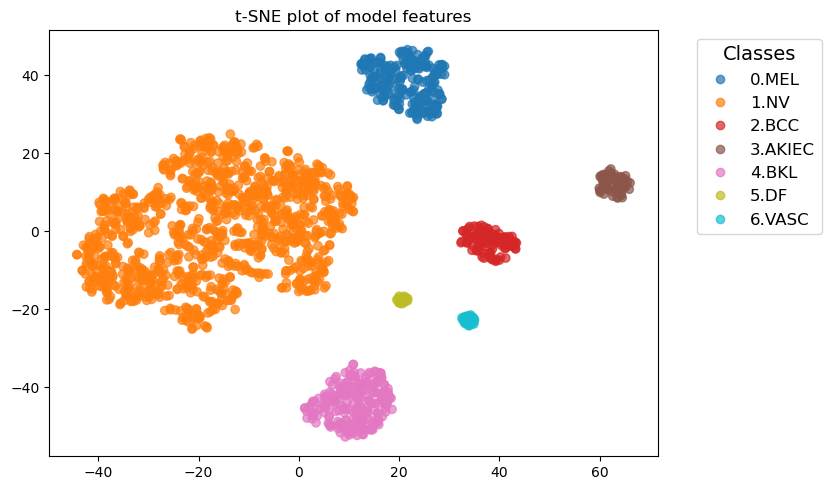

In [44]:
def plot_tsne(features, labels, class_names, save_path=None):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 5))
    
    # Crea il grafico t-SNE
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    
    # Crea la legenda con i pallini colorati e i nomi delle classi
    handles, _ = scatter.legend_elements(prop="colors", alpha=0.7)
    legend_labels = [class_names[int(i)] for i in np.unique(labels)]
    
    plt.legend(handles, legend_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.title('t-SNE plot of model features')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Spazio a destra per la legenda

    # Salva il plot se specificato
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"t-SNE plot saved to: {save_path}")
    
    plt.show()

# Ottieni le labels e le features dal modello
labels, features = validate_tsne(model, val_loader, device)

# Nomi delle classi
class_names = ['0.MEL', '1.NV', '2.BCC', '3.AKIEC', '4.BKL', '5.DF', '6.VASC']

# Percorso di salvataggio
save_path = os.path.join(args['save_dir'], 'Tsne_HAMt_STL.png')

# Visualizza e salva il t-SNE plot
plot_tsne(features, labels, class_names, save_path=save_path)

# Fine-Tuning on Segmentation

In [ ]:
def run_training_segmentation():
    # Usa i dataloader per training, validazione e test
    train_loader = train_segmentation_loader
    val_loader = val_segmentation_loader
    test_loader = test_segmentation_loader

    metrics = Metrics(["epoch", "lr", 
                       "train_loss", "train_iou", "train_dice", 
                       "val_loss", "val_iou", "val_dice", 
                       "test_loss", "test_iou", "test_dice"])

    print("Creating new model...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], 
                               num_classes_binary=2)

    # Carica i pesi del modello classificazione migliore (multiclasse + binaria)
    model_path = os.path.join(args['save_dir'], 'model_best_val_bin+multi.pt')
    model.load_weights(model_path)

    # Converti il modello in modalità segmentazione
    model = model.convert_to_segmentation()  # Aggiungi questa funzione al tuo modello Swin

    # Sposta il modello sulla GPU
    model = model.to(args['device'])

    # Definire la loss function e l'ottimizzatore
    criterion = nn.BCEWithLogitsLoss()  # Usare BCEWithLogitsLoss per output a singolo canale e multi-classe
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])

    # Numero di epoche per il training
    num_epochs = 100

    # Variabili per tenere traccia della migliore IoU su validazione e test
    best_val_iou = 0.0
    best_test_iou = 0.0

    # Training del modello
    for epoch in range(num_epochs):
        # Fase di training
        epoch_loss, iou_score, dice_score = train_seg_model(model, train_loader, criterion, optimizer)
        
        # Fase di validazione
        val_loss, val_iou, val_dice = validate_seg_model(model, val_loader, criterion)

        # Fase di test
        test_loss, test_iou, test_dice = validate_seg_model(model, test_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train IoU: {iou_score:.4f}, Train Dice: {dice_score:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}")

        # Salvataggio dei risultati
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            epoch_loss, 
            iou_score, 
            dice_score,
            val_loss,
            val_iou,
            val_dice,
            test_loss,
            test_iou,
            test_dice,
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], "metrics_segmentation_exp2.csv"))

        # Salvataggio del modello corrente
        model.save_weights(os.path.join(args['save_dir'], 'model_seg_last2.pt'))

        # **Salva il modello se ha la migliore IoU sul validation set**
        if val_iou > best_val_iou:
            print(f"Val IoU migliorata a {val_iou:.4f}, salvataggio del modello migliore (validazione).")
            best_val_iou = val_iou
            model.save_weights(os.path.join(args['save_dir'], 'model_best_val_iou2.pt'))

        # **Salva il modello se ha la migliore IoU sul test set**
        if test_iou > best_test_iou:
            print(f"Test IoU migliorata a {test_iou:.4f}, salvataggio del modello migliore (test).")
            best_test_iou = test_iou
            model.save_weights(os.path.join(args['save_dir'], 'model_best_test_iou2.pt'))

    print("Training completato.")

    # Carica le metriche dal file CSV
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_segmentation_exp2.csv"))

    # Salva i plot di Loss e Accuracy (IoU e Dice coefficient)
    plot_and_save_loss(metrics_data, args['save_dir'])
    plot_and_save_accuracy(metrics_data, args['save_dir'])

# Esegui il training per la segmentazione
run_training_segmentation()

Opening: ISIC_0020896.jpg
Loading model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou2.pt
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_val_iou2.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


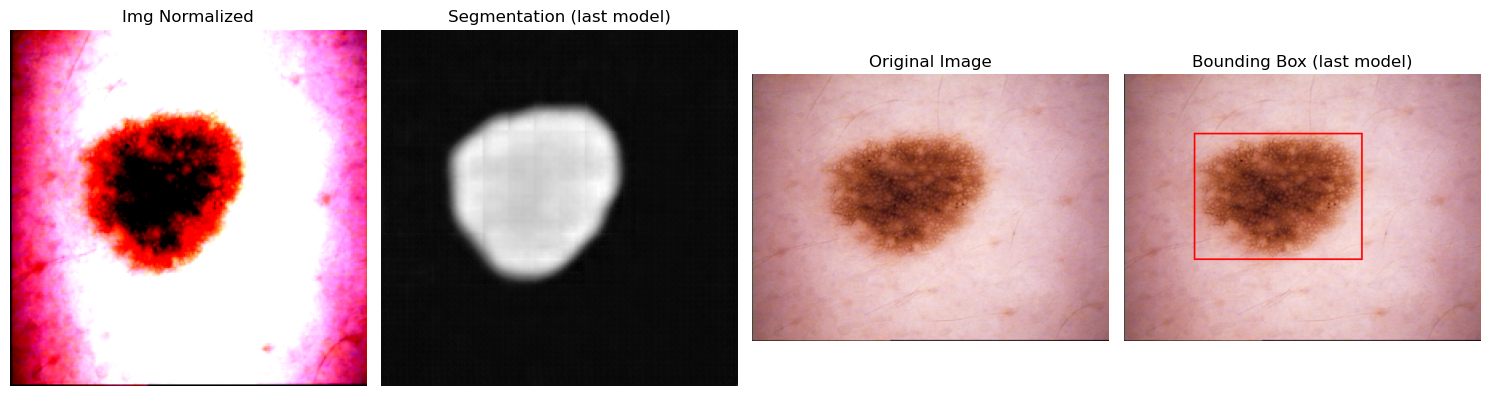

Loading model: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_test_iou2.pt
Loading pre-trained: experiments/1.3.1.Swin_seg+class_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_test_iou2.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


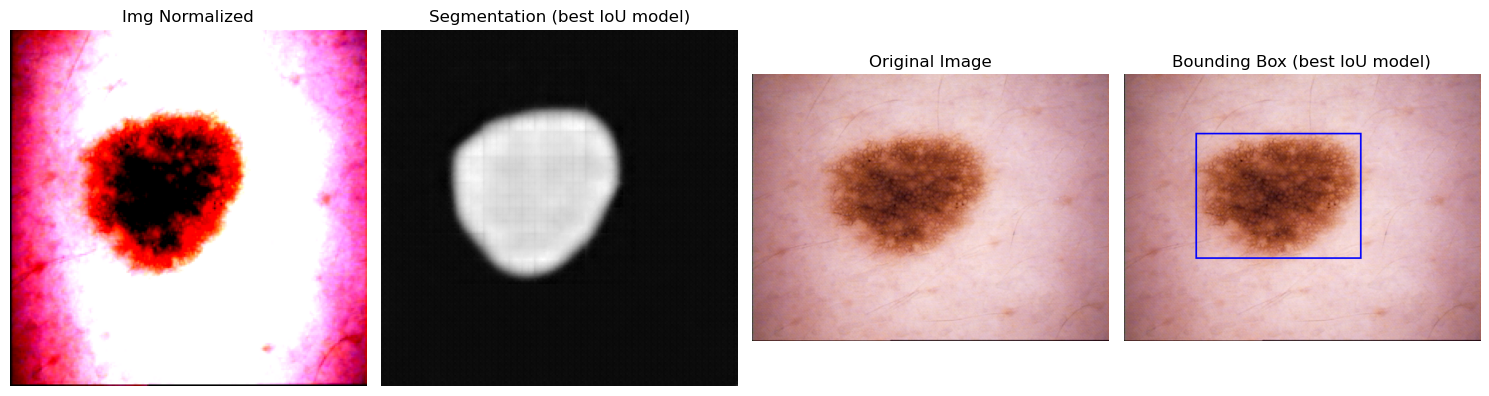

In [33]:
def test_seg2():
    seg_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Selezione casuale dell'immagine direttamente dalla directory di test (senza sottocartelle)
    root_dir = args['test_dir_seg']  # Questa è la directory di test senza sottocartelle
    images = os.listdir(root_dir)
    valid_extensions = ('.jpg', '.jpeg', '.png')  # Definisci le estensioni valide
    images = [img for img in images if img.endswith(valid_extensions)]  # Filtra le immagini valide

    if len(images) == 0:
        raise ValueError(f"Nessuna immagine trovata nella directory: {root_dir}")

    idx = random.randint(0, len(images) - 1)
    print("Opening:", images[idx])
    img = Image.open(os.path.join(root_dir, images[idx]))
    img_tensor = seg_transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Funzione per eseguire il modello e ottenere l'output della segmentazione
    def run_model(model_path):
        print(f"Loading model: {model_path}")
        model = SwinSeg()  # Assicurati che questa classe sia definita correttamente
        model.load_weights(model_path)
        model = model.to(args['device'])
        model.eval()

        with torch.no_grad():
            output = model(img_tensor.to(args['device']))
        segmentation = output.squeeze().cpu().numpy()
        return segmentation

    # Funzione per ottenere il bounding box dalla segmentazione
    def get_bounding_box(segmentation, img):
        binary_mask = (segmentation > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None, None, None, None
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Scala il bounding box in base alla dimensione originale dell'immagine
        orig_width, orig_height = img.size
        x_scale = orig_width / 224
        y_scale = orig_height / 224
        x, y, w, h = int(x * x_scale), int(y * y_scale), int(w * x_scale), int(h * y_scale)
        
        return x, y, w, h

    # Funzione per visualizzare i risultati
    def plot_results(segmentation, img, model_name, box_color):
        x, y, w, h = get_bounding_box(segmentation, img)

        # Crea una copia dell'immagine con la bounding box
        img_with_box = img.copy()
        if x is not None:  # Se c'è una bounding box valida
            draw = ImageDraw.Draw(img_with_box)
            draw.rectangle([x, y, x+w, y+h], outline=box_color, width=3)

        # Plot dei risultati con dimensioni 15x5 per ogni immagine
        plt.figure(figsize=(15, 5))

        # Immagine normalizzata
        plt.subplot(1, 4, 1)
        img_normalized = img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        plt.imshow(img_normalized)
        plt.title('Img Normalized')
        plt.axis('off')

        # Segmentazione
        plt.subplot(1, 4, 2)
        plt.imshow(segmentation, cmap='gray')
        plt.title(f'Segmentation ({model_name})')
        plt.axis('off')

        # Immagine originale
        plt.subplot(1, 4, 3)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Immagine con bounding box
        plt.subplot(1, 4, 4)
        plt.imshow(img_with_box)
        plt.title(f'Bounding Box ({model_name})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Esegui il modello "last"
    segmentation_last = run_model(os.path.join(args['save_dir'], 'model_best_val_iou2.pt'))
    plot_results(segmentation_last, img, "last model", "red")

    # Esegui il modello "best IoU"
    segmentation_best = run_model(os.path.join(args['save_dir'], 'model_best_test_iou2.pt'))
    plot_results(segmentation_best, img, "best IoU model", "blue")

test_seg2()